In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
import random as python_random
from keras.initializers import GlorotUniform
from keras.initializers import Orthogonal

np.random.seed(42)
tf.random.set_seed(42)
python_random.seed(42)

2024-06-04 01:27:24.760376: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 01:27:24.780663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 01:27:24.780678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 01:27:24.781237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 01:27:24.784879: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [3]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    # print("data", data[:15])
    # print("target", target[:15])
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [4]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data['ACU_4D'] = data['LMCADY'].rolling(window=4).sum()
    data['ACU_3D'] = data['LMCADY'].rolling(window=3).sum()
    data['ACU_2D'] = data['LMCADY'].rolling(window=2).sum()

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    result = data
    # print(result.head(10))
    return result

In [5]:
def prepare_data(df, target_column, n_steps, feature_list = []):

    df = modify_data(df)
    df.to_csv('../output/modified_data.csv', index=False)

    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    features = features.drop(columns = ['Date'])
    features = features[feature_list]
    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X, y = create_sequences(features_scaled, target, n_steps)
    # for i in range(15):
    #     print(X[i][0][0], y[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle = False)

    return X_train, X_test, y_train, y_test

In [6]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [7]:
def build_model(input_shape, md_prm: dict):

    model = Sequential()

    initializer = GlorotUniform(seed=42)
    # initializer = Orthogonal(seed=42)
    model.add(LSTM(md_prm['lstm_units'], input_shape=input_shape, kernel_initializer = initializer))
    model.add(Dense(1, kernel_initializer = initializer))

    model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error', metrics=[rmse])
    return model

In [8]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):

    early_stopping = EarlyStopping(
        monitor             ='val_loss',
        patience            =15,
        verbose             =1,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs              =epochs,
        batch_size          =batch_size,
        verbose             =verbose,
        validation_split    =0.05,
        callbacks           =[early_stopping]
    )

    return history

In [9]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [10]:
def plot_predictions(y_true, y_pred, n = -1, title="Prediction vs Actual Data", markersize=3):

    if n != -1:
        n = min(n, len(y_true), len(y_pred))

        y_true = y_true[-n:]
        y_pred = y_pred[-n:]

    plt.figure(figsize=(18, 3))
    plt.plot(y_true, label='Actual Values'   , marker='o', linestyle='-' , markersize=markersize)
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [11]:
def trend_accuracy(y_true, y_pred):
    trend_up_true = 0
    trend_down_true = 0
    trend_up_pred = 0
    trend_down_pred = 0

    for j in range(len(y_true)-1):
        if y_true[j] > 0.0:
            trend_up_pred += 1
            if y_pred[j] > 0.0:
                trend_up_true += 1
        if y_true[j] < 0.0:
            trend_down_pred += 1
            if y_pred[j] < 0.0:
                trend_down_true += 1

    trend_true = trend_up_true + trend_down_true
    trend_pred = trend_up_pred + trend_down_pred 

    trend_up_accuracy = trend_up_true/trend_up_pred
    trend_down_accuracy = trend_down_true/trend_down_pred
    trend_accuracy = trend_true/trend_pred

    return trend_accuracy, trend_up_accuracy, trend_down_accuracy

In [12]:
n_steps_options     = [40,80,120]
batch_size_options  = [128,64]
epochs_options      = [100]

lstm_units_options  = [25,50,75,100]
activation_options  = ['relu']
dropout_options     = [.15, .20]
num_layers_options  = [2]

# variable_options = ['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']
# # # xau discarded
# modified_lists = [variable_options[:i] + variable_options[i+1:] for i in range(len(variable_options))]
# print(modified_lists)
modified_lists = [['LMCADS03','LMCADY','SPX','MXWD','XAG','XAU','ACU_5D','ACU_4D','ACU_3D','ACU_2D']]

# Crear combinaciones de parámetros
model_params_combinations = list(itertools.product(
    n_steps_options     ,
    lstm_units_options,
    activation_options,
    dropout_options,
    num_layers_options, 
    batch_size_options,
    epochs_options,
    modified_lists
))
target_column = 'LMCADY_acu_5d_log'

In [13]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 48


In [14]:
def run_model_iterations():
    top_results = []
    i = 1
    for params in model_params_combinations:
        n_steps, lstm_units, activation, dropout, num_layers, batch_size, epochs, var_options = params
        try:

            # data load
            df = load_data("../input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            print("Params: n_steps: {}, lstm_units: {}, activation: {}, dropout: {}, num_layers: {}".format(
                n_steps, lstm_units, activation, dropout, num_layers))

            # data preparation
            print("Variables used: {}".format(var_options))
            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps, var_options)

            # build model
            model_params = {
                'lstm_units': lstm_units,
                'activation': activation,
                'dropout'   : dropout,
                'num_layers': num_layers
            }
            input_shape = (X_train.shape[1], X_train.shape[2])
            print("Input shape: {}".format(input_shape))
            model = build_model(input_shape, model_params)
            print(model.summary())

            # model train

            # if i == 5:
            if True:
                history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                # model evaluation
                y_pred      = model.predict(X_test)
                rmse_score  = math.sqrt(mean_squared_error(y_test, y_pred))
                std_dev     = np.std(y_test)

                print("Pred std dev: {:.6f}, test std dev: {:.6f}".format(np.std(y_pred), std_dev))

                diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0

                result = {
                    'n_steps'   : n_steps,
                    'lstm_units': lstm_units,
                    'activation': activation,
                    'dropout'   : dropout,
                    'num_layers': num_layers,
                    'batch_size': batch_size,
                    'epochs'    : epochs,
                    'rmse'      : rmse_score,
                    'std_dev'   : std_dev,
                    'diff'      : diff,
                    'predictions': y_pred,
                    'true_values': y_test,
                    'feature_list': var_options
                }

                top_results.append(result)
                top_results = sorted(top_results, key=lambda x: x['diff'])

                plot_predictions(result['true_values'], result['predictions'], -1, title="It. {}".format(i))

                print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(rmse_score, std_dev, diff))
            print("Completed Iteration {}/{}".format(i, n_iterations))

        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i += 1

    return top_results


Iteration 1/48
Params: n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)


2024-06-04 01:27:26.001213: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 01:27:26.019903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 01:27:26.020010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                3600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


2024-06-04 01:27:28.733102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-04 01:27:29.048882: I external/local_xla/xla/service/service.cc:168] XLA service 0x7623341de290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-04 01:27:29.048897: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-04 01:27:29.051643: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717482449.103700  454920 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Restoring model weights from the end of the best epoch: 30.
Epoch 45: early stopping
9/9 [==============================] - 0s 1ms/step
Pred std dev: 0.009370, test std dev: 0.021968


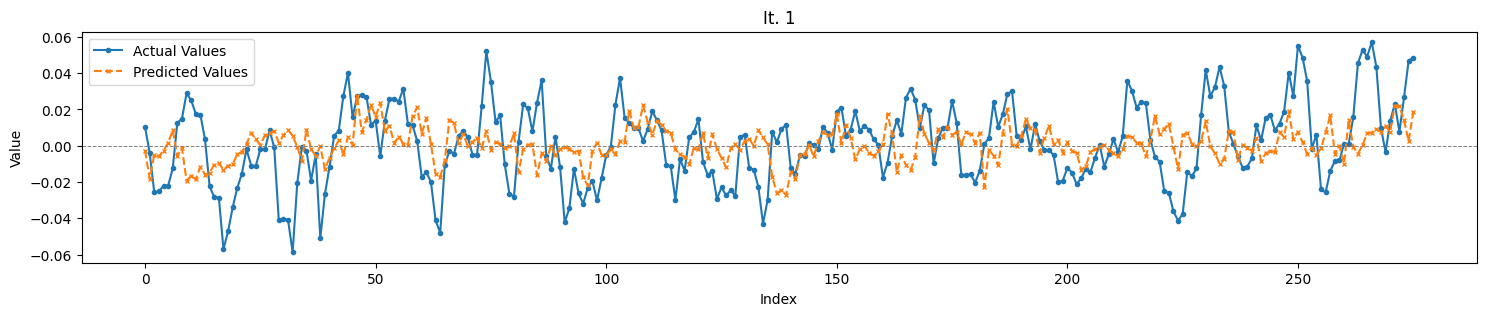

RMSE: 0.022214, STD_DEV: 0.021968, DIFF: 0.006544
Completed Iteration 1/48

Iteration 2/48
Params: n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 25)                3600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________

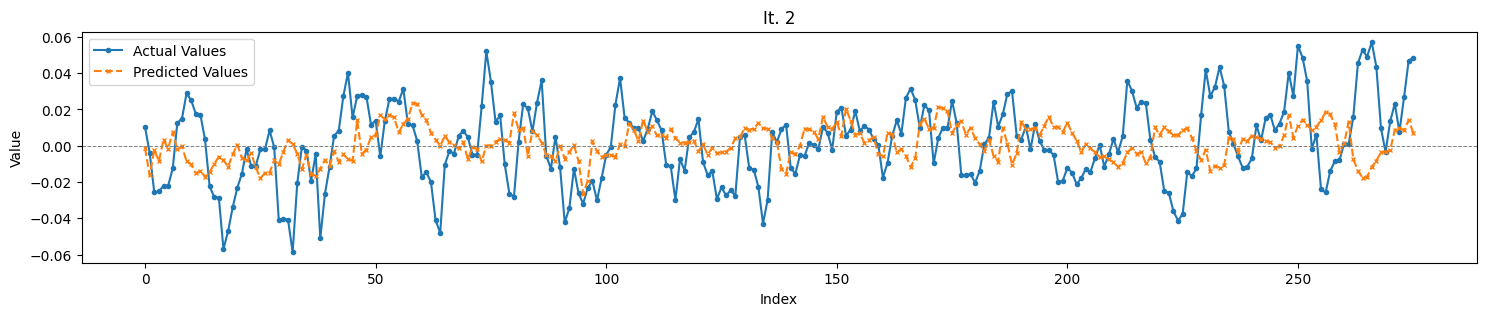

RMSE: 0.023717, STD_DEV: 0.021968, DIFF: 0.008133
Completed Iteration 2/48

Iteration 3/48
Params: n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25)                3600      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________

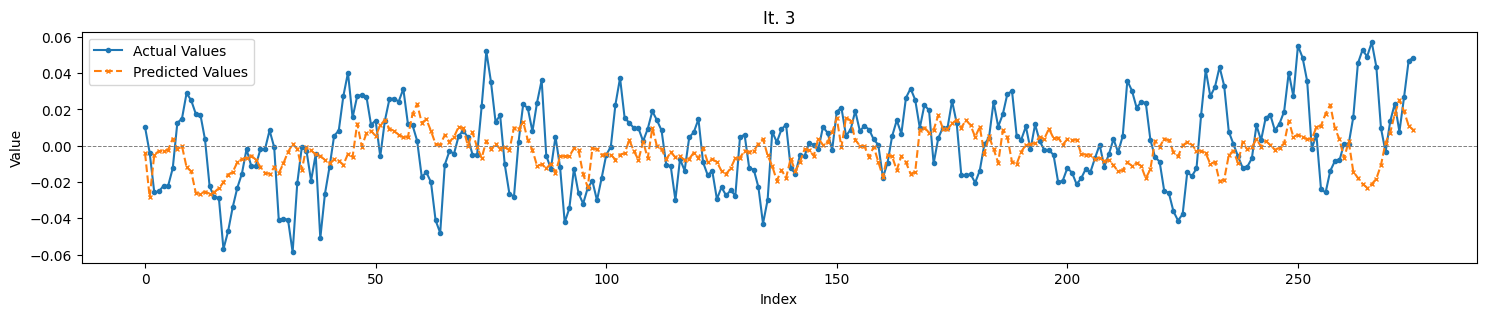

RMSE: 0.023929, STD_DEV: 0.021968, DIFF: 0.008041
Completed Iteration 3/48

Iteration 4/48
Params: n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 25)                3600      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________

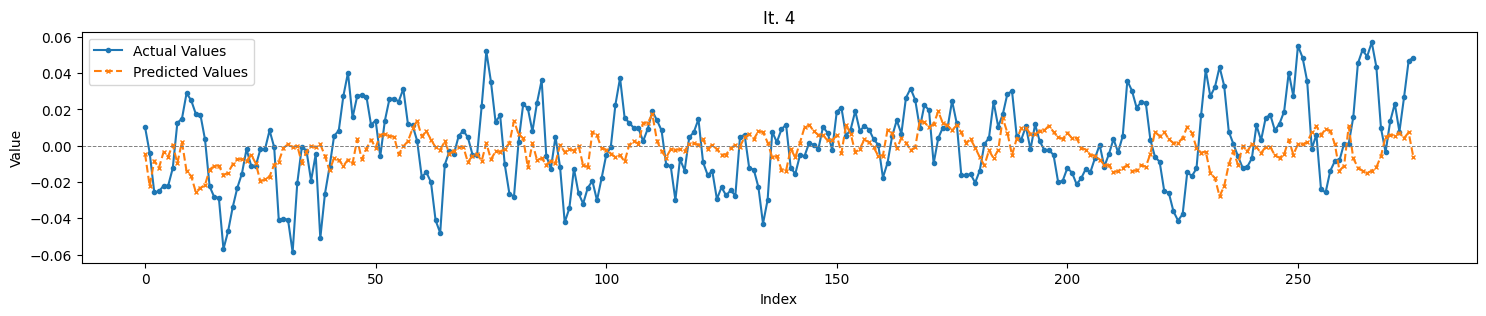

RMSE: 0.024587, STD_DEV: 0.021968, DIFF: 0.009450
Completed Iteration 4/48

Iteration 5/48
Params: n_steps: 40, lstm_units: 50, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                12200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

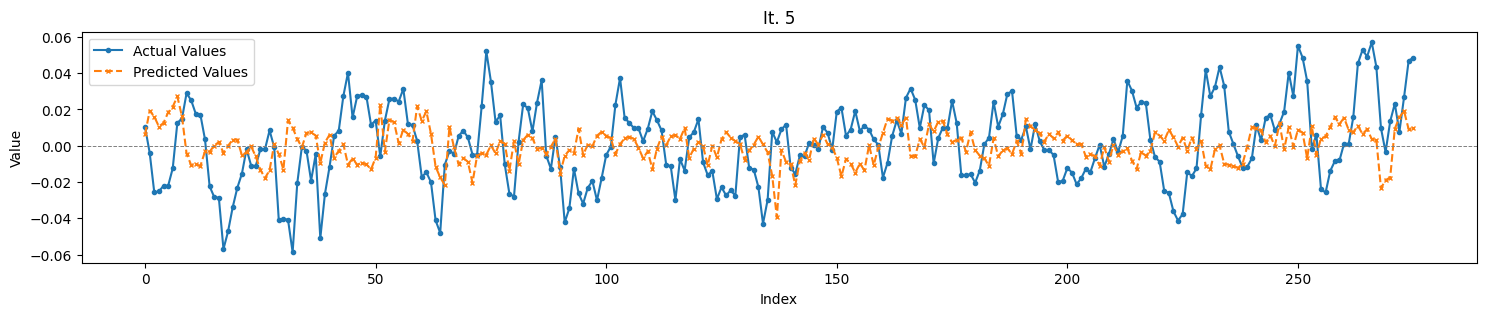

RMSE: 0.024083, STD_DEV: 0.021968, DIFF: 0.008479
Completed Iteration 5/48

Iteration 6/48
Params: n_steps: 40, lstm_units: 50, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                12200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

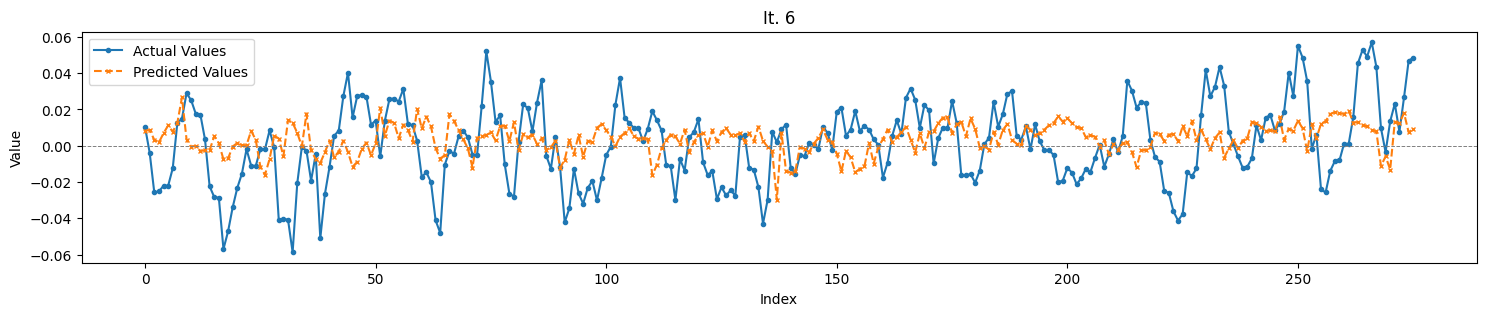

RMSE: 0.023349, STD_DEV: 0.021968, DIFF: 0.008393
Completed Iteration 6/48

Iteration 7/48
Params: n_steps: 40, lstm_units: 50, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                12200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

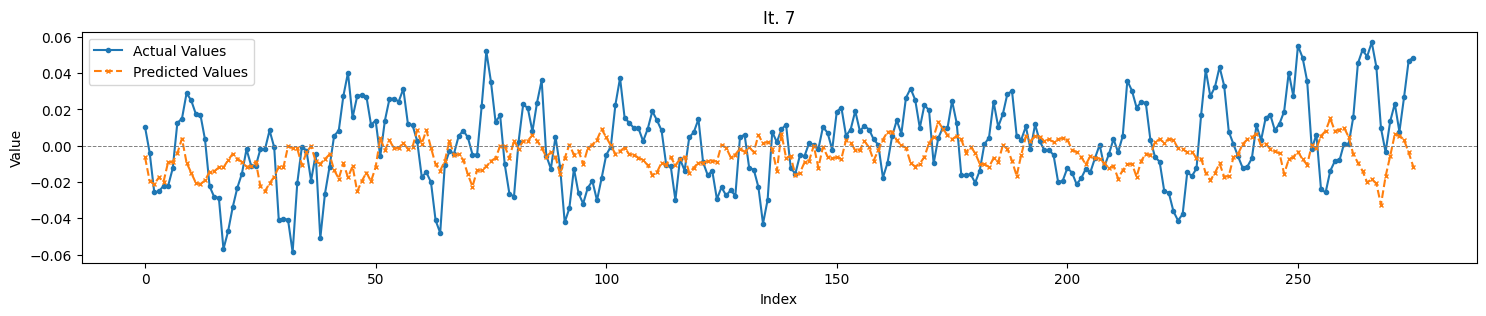

RMSE: 0.025475, STD_DEV: 0.021968, DIFF: 0.010510
Completed Iteration 7/48

Iteration 8/48
Params: n_steps: 40, lstm_units: 50, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                12200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

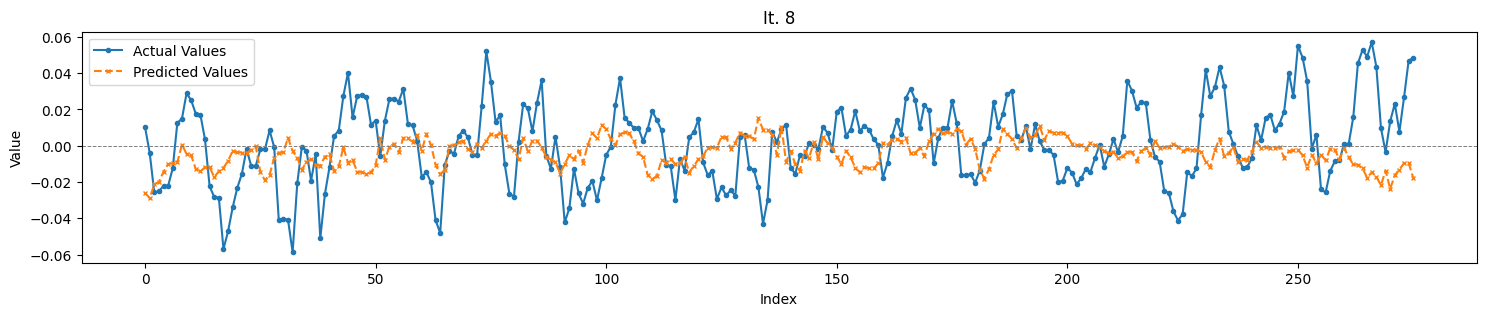

RMSE: 0.024287, STD_DEV: 0.021968, DIFF: 0.009461
Completed Iteration 8/48

Iteration 9/48
Params: n_steps: 40, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 75)                25800     
                                                                 
 dense_8 (Dense)             (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

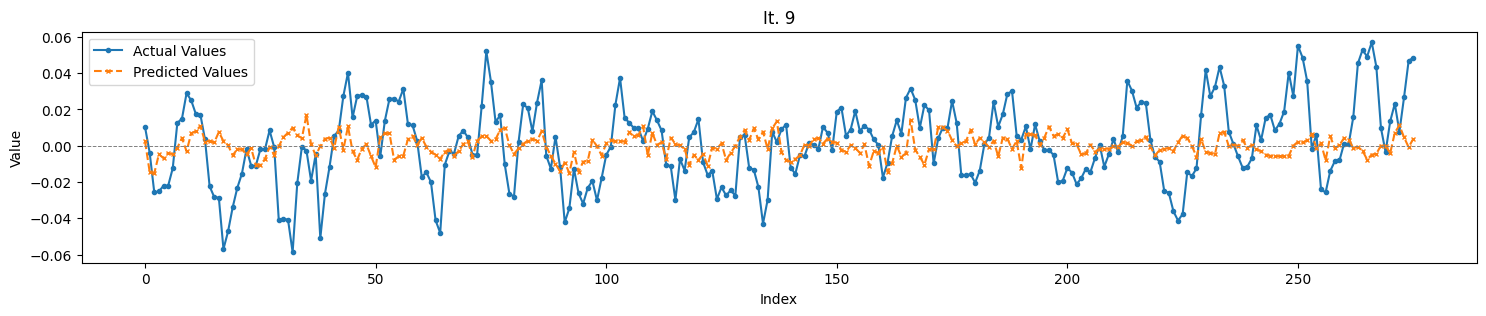

RMSE: 0.022122, STD_DEV: 0.021968, DIFF: 0.008283
Completed Iteration 9/48

Iteration 10/48
Params: n_steps: 40, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 75)                25800     
                                                                 
 dense_9 (Dense)             (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

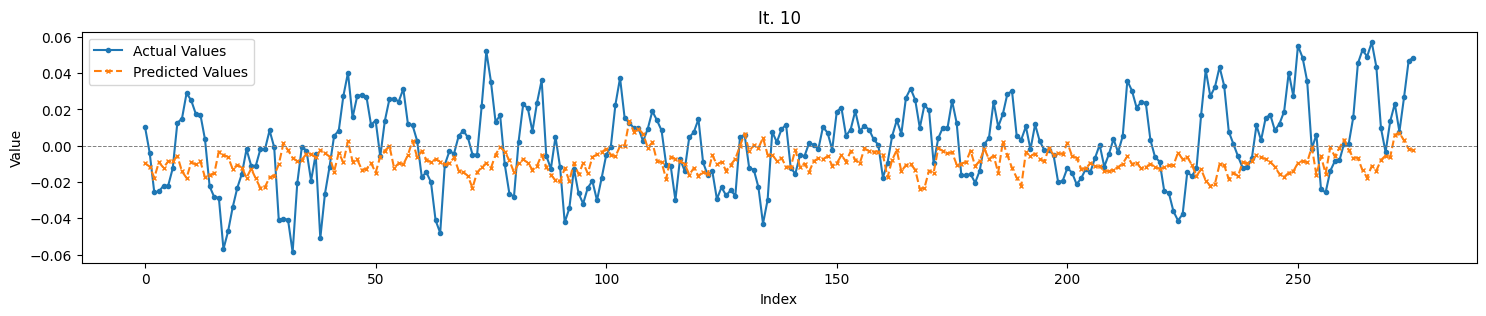

RMSE: 0.025013, STD_DEV: 0.021968, DIFF: 0.010953
Completed Iteration 10/48

Iteration 11/48
Params: n_steps: 40, lstm_units: 75, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 75)                25800     
                                                                 
 dense_10 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

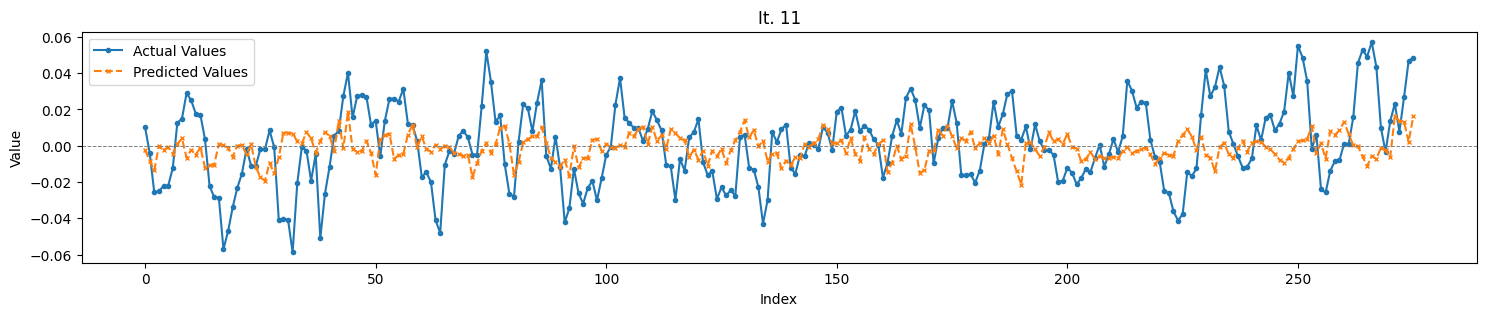

RMSE: 0.022662, STD_DEV: 0.021968, DIFF: 0.008212
Completed Iteration 11/48

Iteration 12/48
Params: n_steps: 40, lstm_units: 75, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 75)                25800     
                                                                 
 dense_11 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

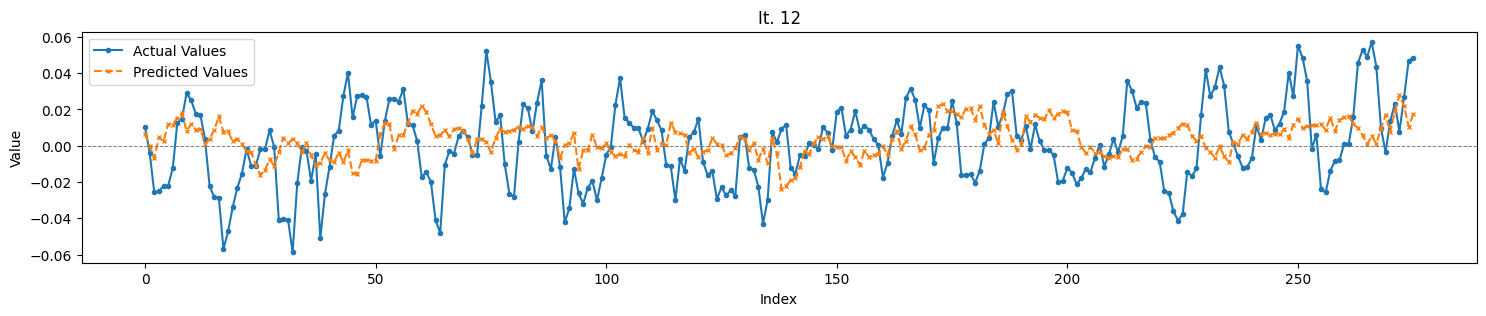

RMSE: 0.023654, STD_DEV: 0.021968, DIFF: 0.008213
Completed Iteration 12/48

Iteration 13/48
Params: n_steps: 40, lstm_units: 100, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100)               44400     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

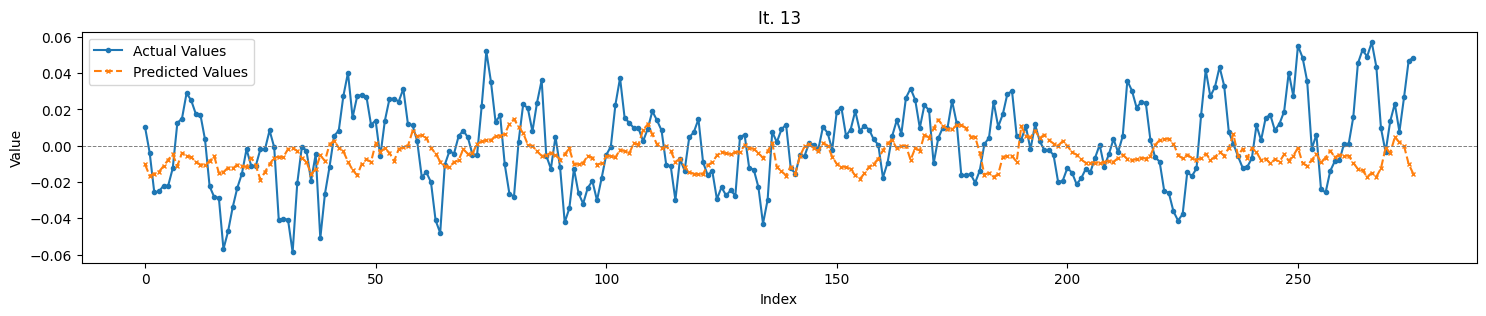

RMSE: 0.023962, STD_DEV: 0.021968, DIFF: 0.009547
Completed Iteration 13/48

Iteration 14/48
Params: n_steps: 40, lstm_units: 100, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 100)               44400     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

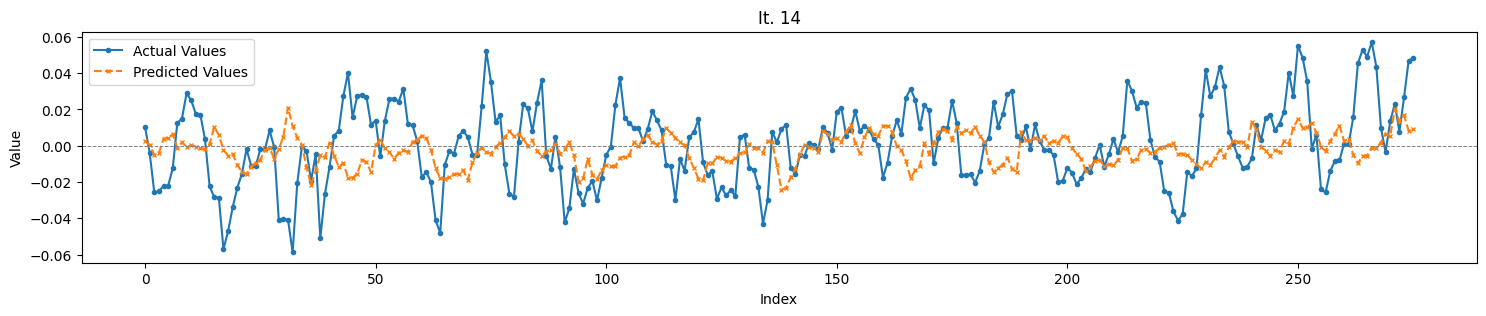

RMSE: 0.023653, STD_DEV: 0.021968, DIFF: 0.008567
Completed Iteration 14/48

Iteration 15/48
Params: n_steps: 40, lstm_units: 100, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 100)               44400     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

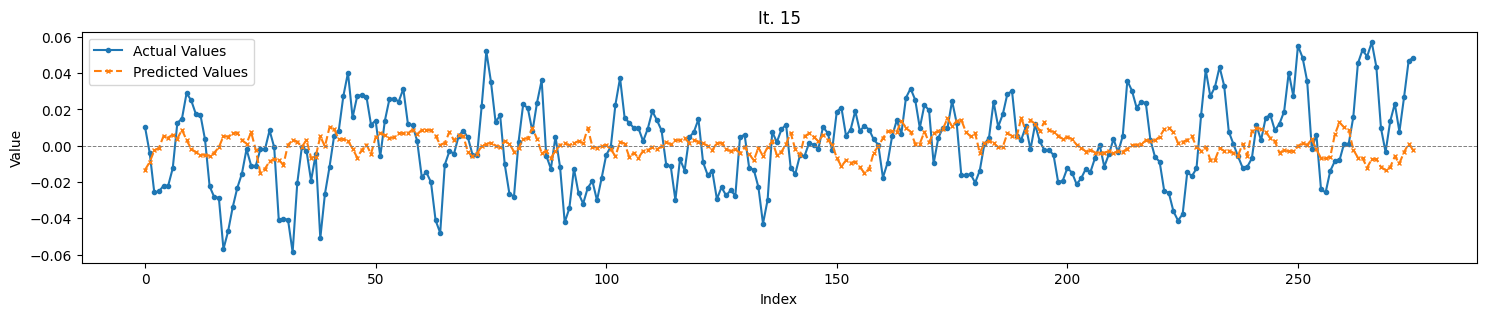

RMSE: 0.023428, STD_DEV: 0.021968, DIFF: 0.009436
Completed Iteration 15/48

Iteration 16/48
Params: n_steps: 40, lstm_units: 100, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100)               44400     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

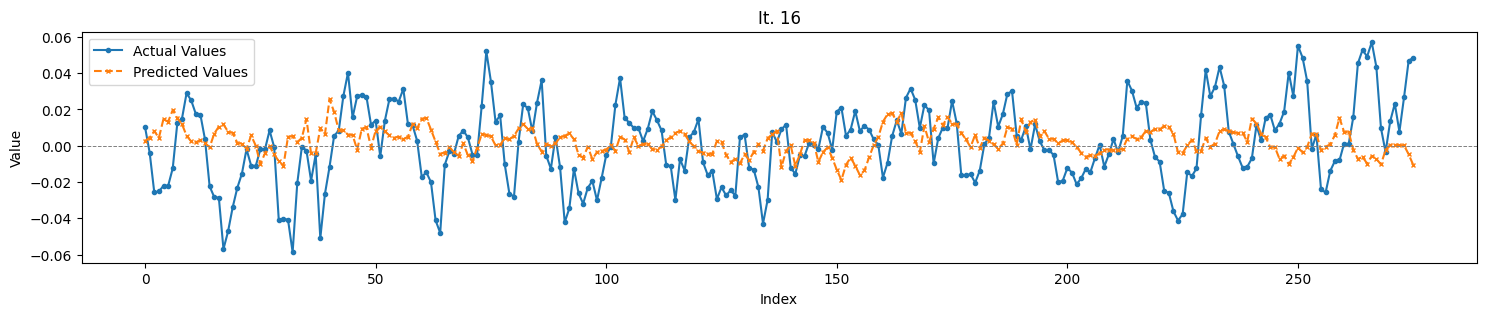

RMSE: 0.023540, STD_DEV: 0.021968, DIFF: 0.009009
Completed Iteration 16/48

Iteration 17/48
Params: n_steps: 80, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 25)                3600      
                                                                 
 dense_16 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

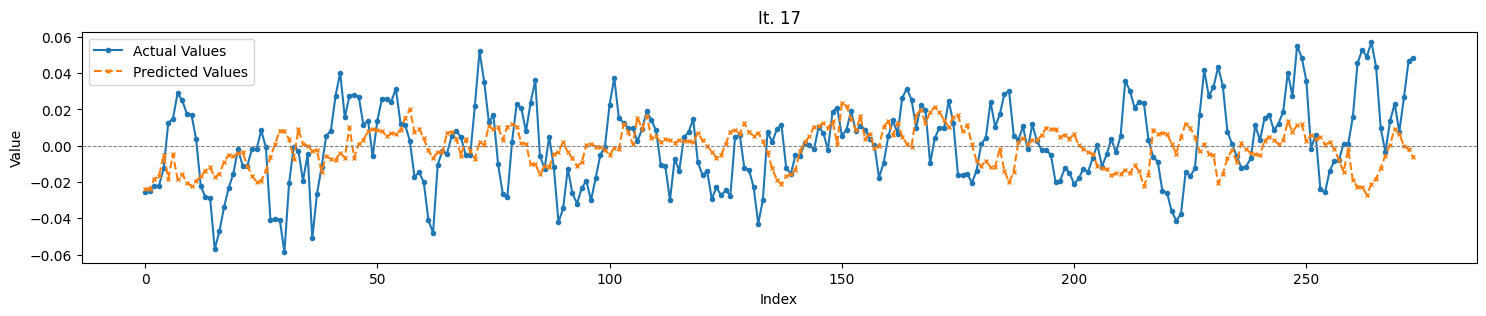

RMSE: 0.024932, STD_DEV: 0.022040, DIFF: 0.008688
Completed Iteration 17/48

Iteration 18/48
Params: n_steps: 80, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 25)                3600      
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

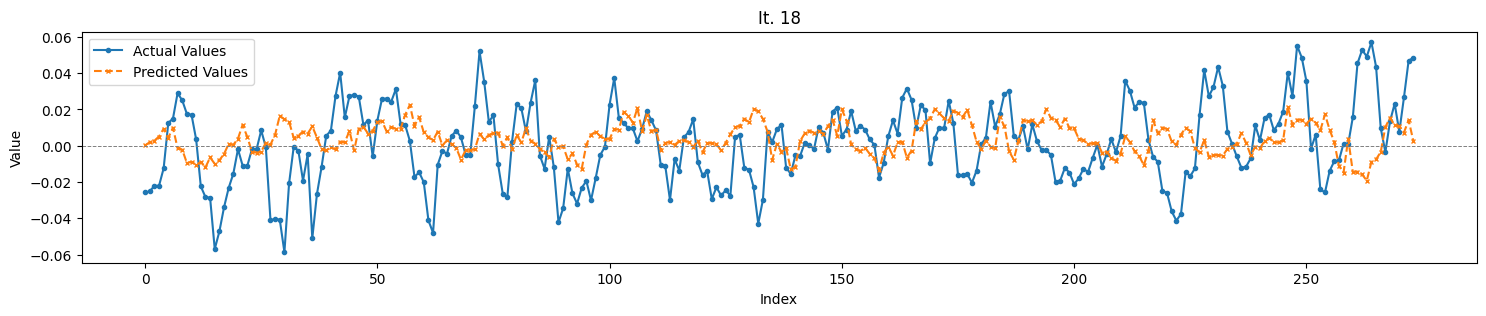

RMSE: 0.024004, STD_DEV: 0.022040, DIFF: 0.008848
Completed Iteration 18/48

Iteration 19/48
Params: n_steps: 80, lstm_units: 25, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 25)                3600      
                                                                 
 dense_18 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

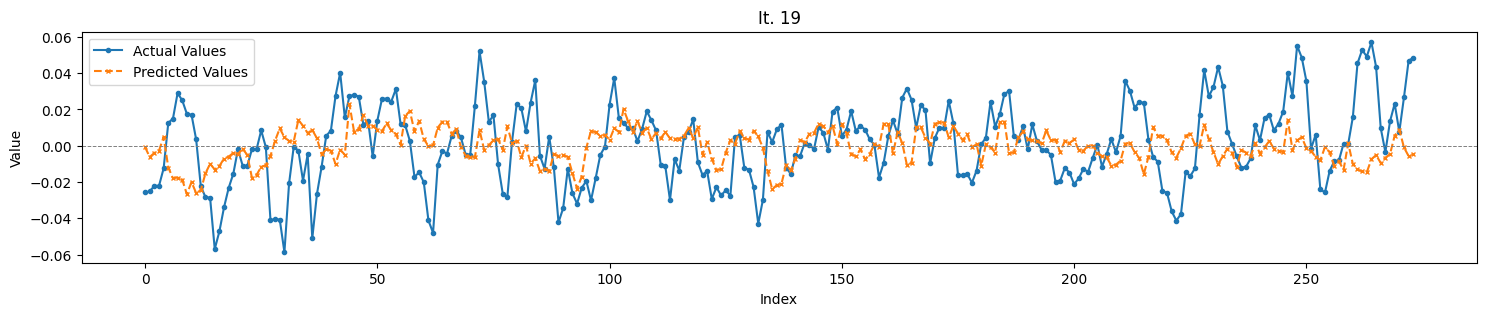

RMSE: 0.023492, STD_DEV: 0.022040, DIFF: 0.007964
Completed Iteration 19/48

Iteration 20/48
Params: n_steps: 80, lstm_units: 25, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 25)                3600      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

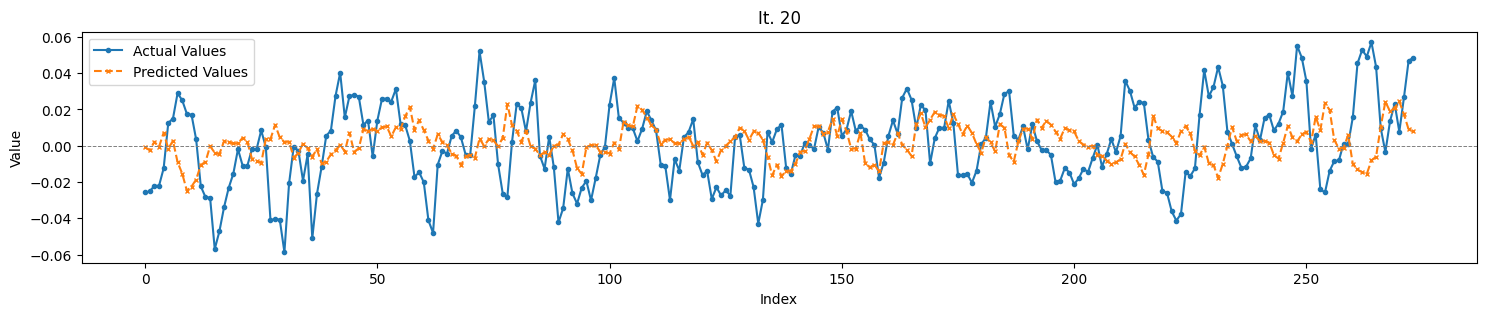

RMSE: 0.024357, STD_DEV: 0.022040, DIFF: 0.008873
Completed Iteration 20/48

Iteration 21/48
Params: n_steps: 80, lstm_units: 50, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 50)                12200     
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

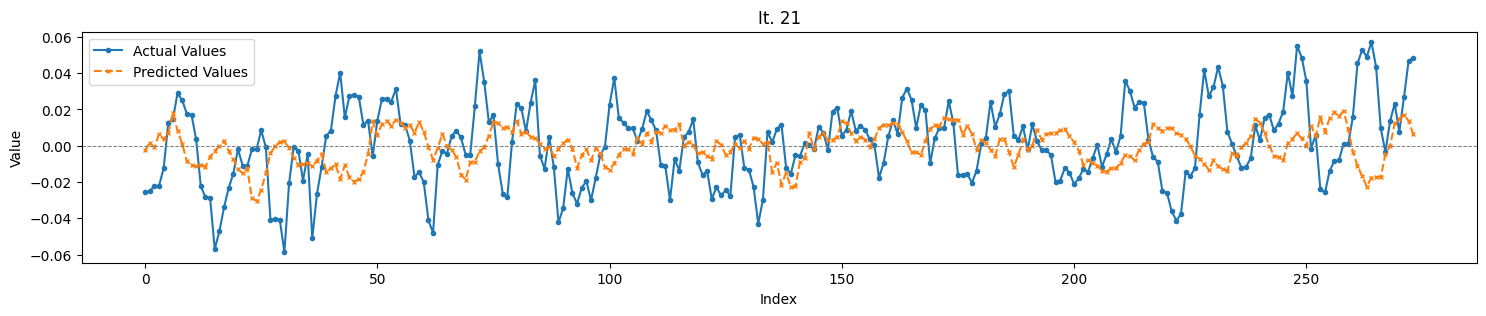

RMSE: 0.024855, STD_DEV: 0.022040, DIFF: 0.008991
Completed Iteration 21/48

Iteration 22/48
Params: n_steps: 80, lstm_units: 50, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 50)                12200     
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

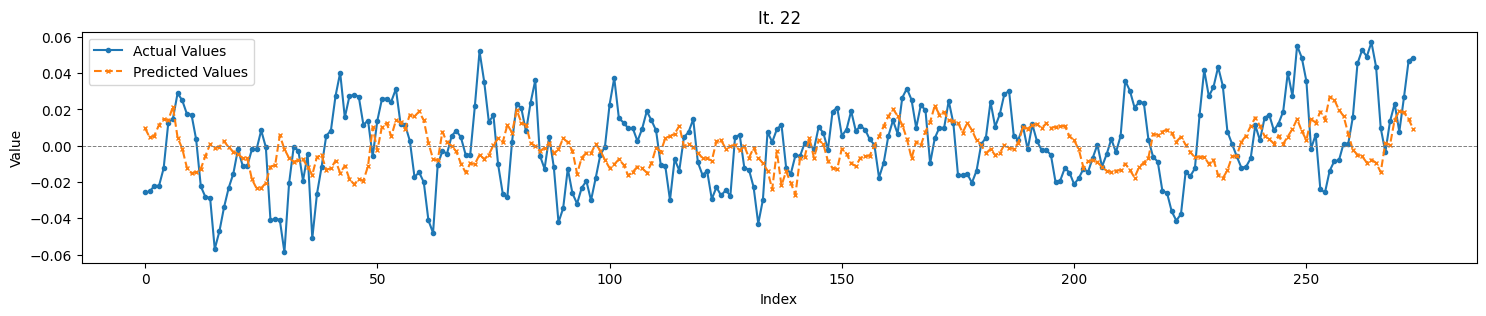

RMSE: 0.025257, STD_DEV: 0.022040, DIFF: 0.008929
Completed Iteration 22/48

Iteration 23/48
Params: n_steps: 80, lstm_units: 50, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 50)                12200     
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

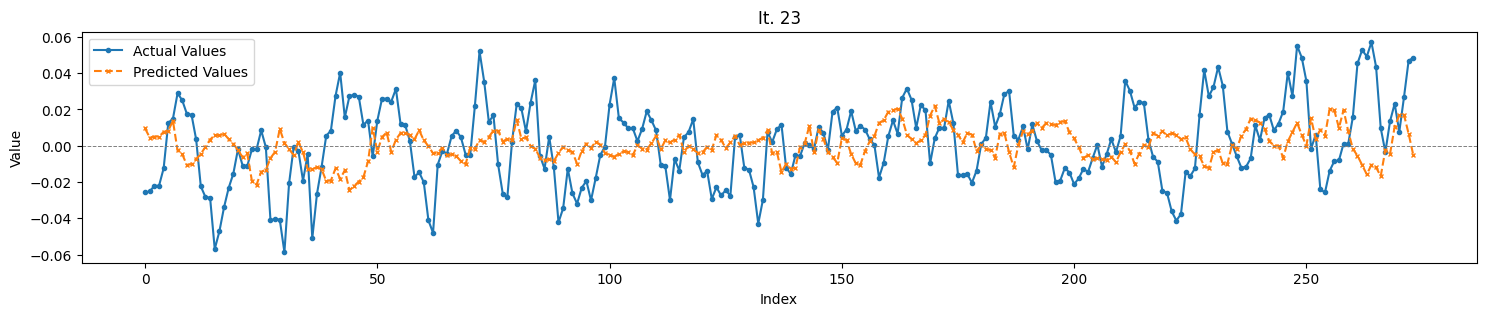

RMSE: 0.024813, STD_DEV: 0.022040, DIFF: 0.009471
Completed Iteration 23/48

Iteration 24/48
Params: n_steps: 80, lstm_units: 50, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 50)                12200     
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

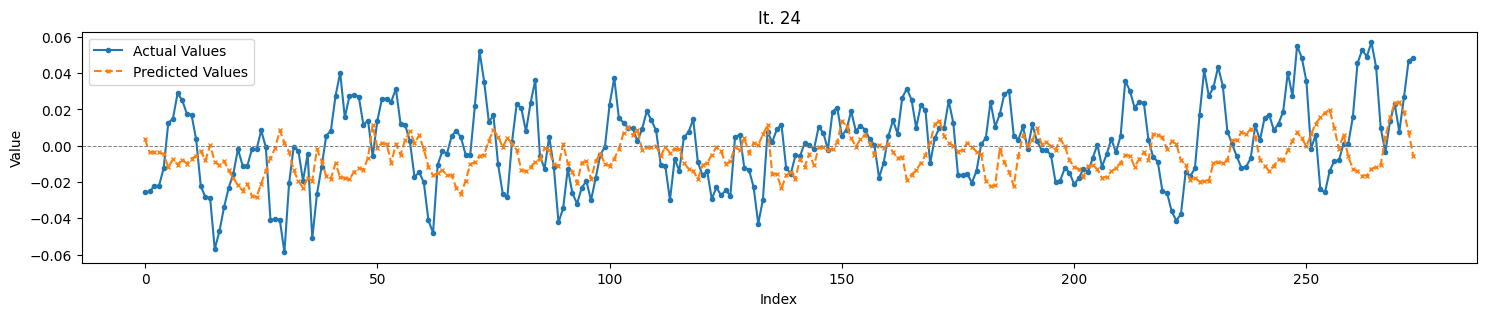

RMSE: 0.025395, STD_DEV: 0.022040, DIFF: 0.009540
Completed Iteration 24/48

Iteration 25/48
Params: n_steps: 80, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 75)                25800     
                                                                 
 dense_24 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

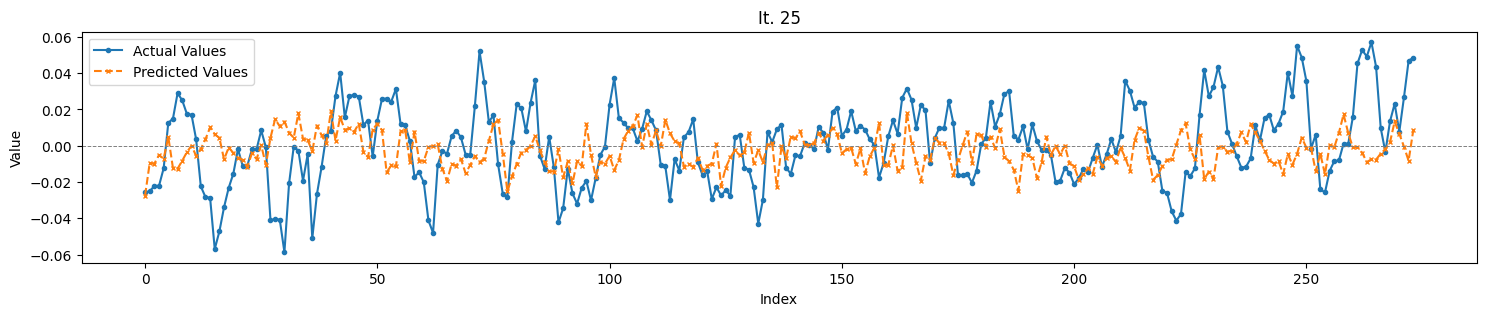

RMSE: 0.024076, STD_DEV: 0.022040, DIFF: 0.008515
Completed Iteration 25/48

Iteration 26/48
Params: n_steps: 80, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 75)                25800     
                                                                 
 dense_25 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

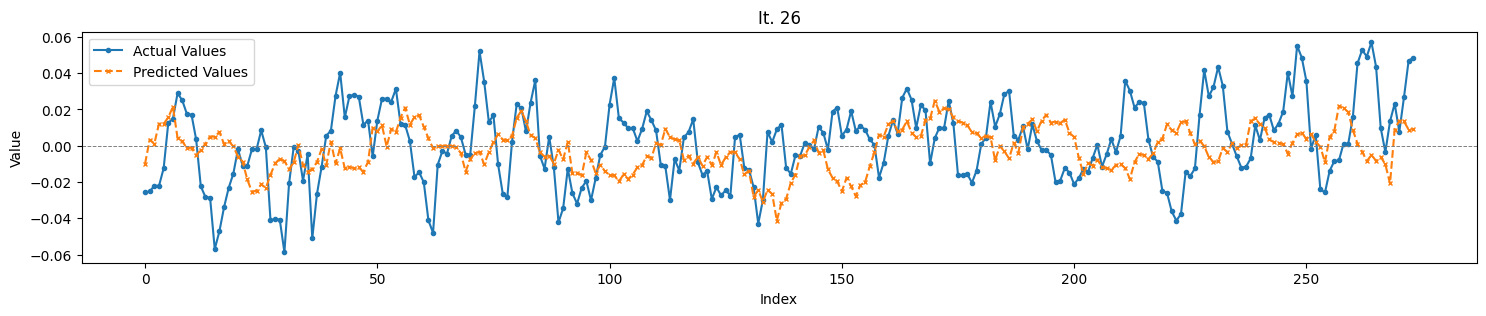

RMSE: 0.024815, STD_DEV: 0.022040, DIFF: 0.007900
Completed Iteration 26/48

Iteration 27/48
Params: n_steps: 80, lstm_units: 75, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 75)                25800     
                                                                 
 dense_26 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

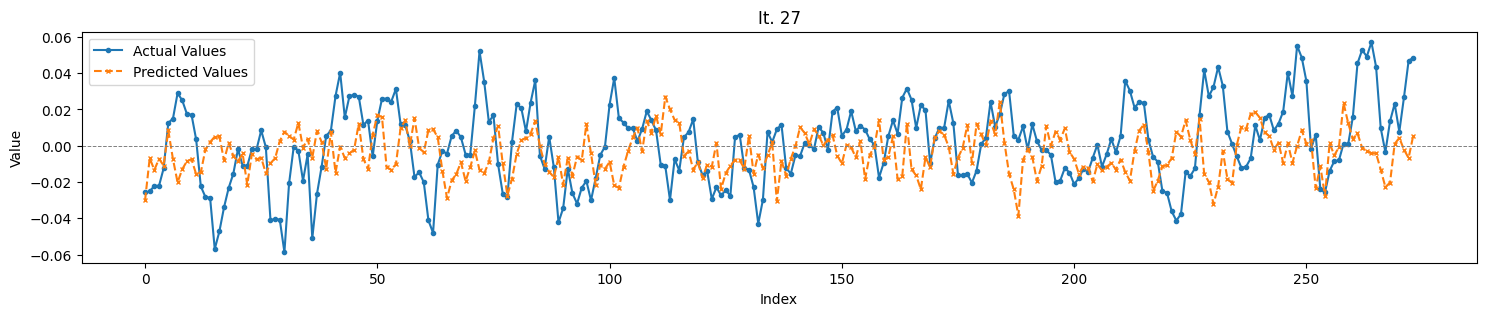

RMSE: 0.025491, STD_DEV: 0.022040, DIFF: 0.008713
Completed Iteration 27/48

Iteration 28/48
Params: n_steps: 80, lstm_units: 75, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 75)                25800     
                                                                 
 dense_27 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

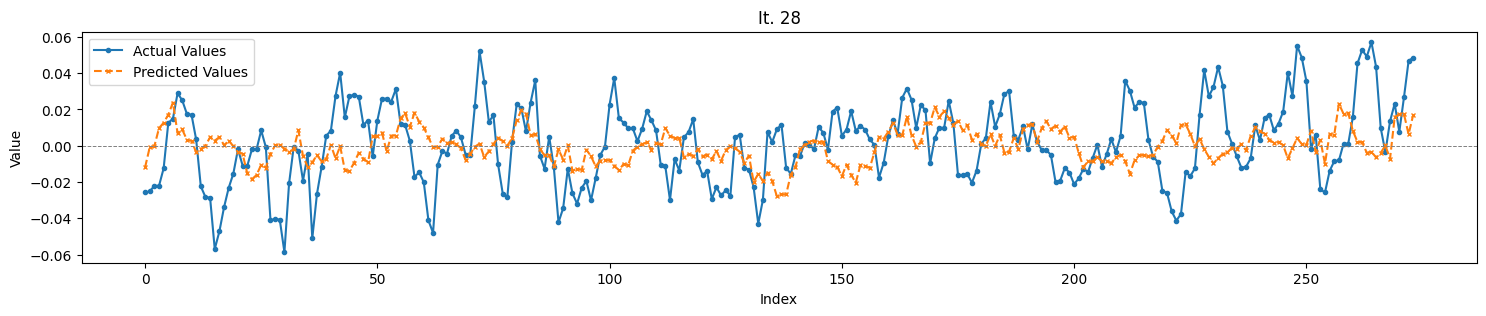

RMSE: 0.023485, STD_DEV: 0.022040, DIFF: 0.007821
Completed Iteration 28/48

Iteration 29/48
Params: n_steps: 80, lstm_units: 100, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 100)               44400     
                                                                 
 dense_28 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

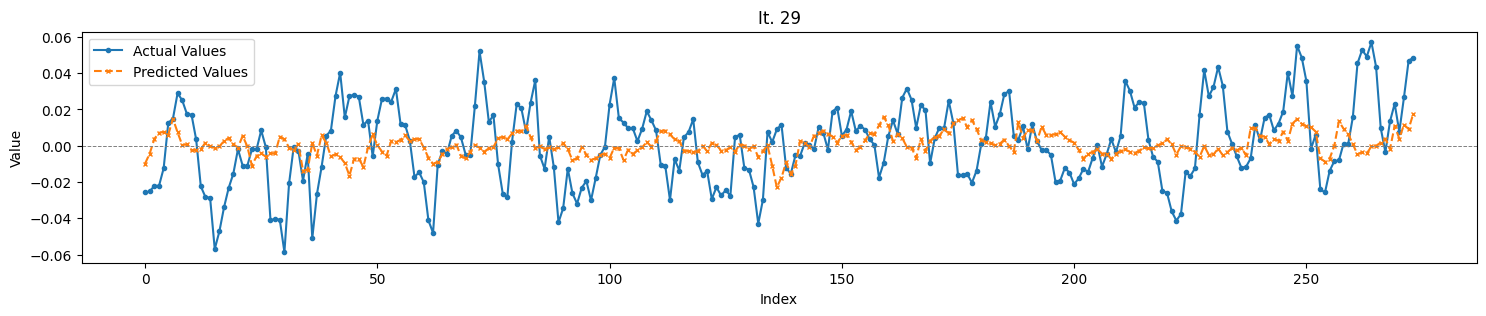

RMSE: 0.022350, STD_DEV: 0.022040, DIFF: 0.008193
Completed Iteration 29/48

Iteration 30/48
Params: n_steps: 80, lstm_units: 100, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 100)               44400     
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

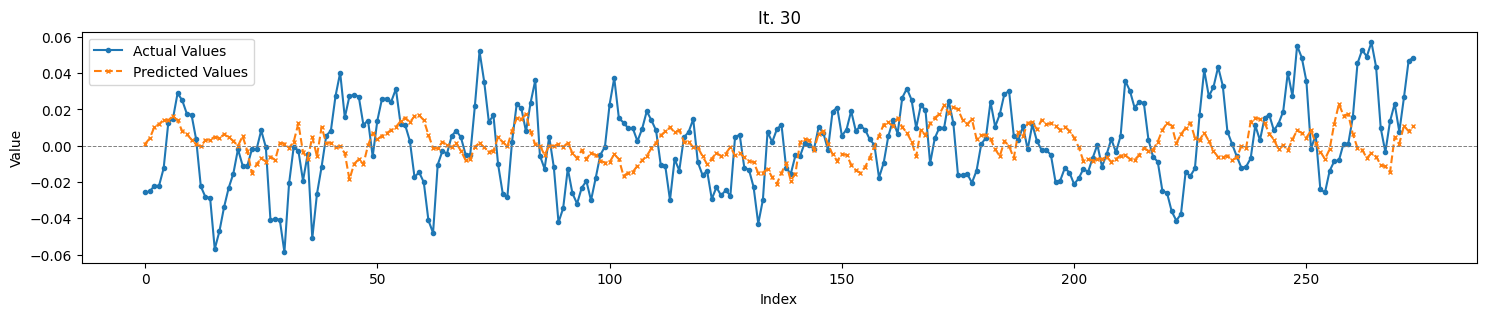

RMSE: 0.023828, STD_DEV: 0.022040, DIFF: 0.008396
Completed Iteration 30/48

Iteration 31/48
Params: n_steps: 80, lstm_units: 100, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 100)               44400     
                                                                 
 dense_30 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

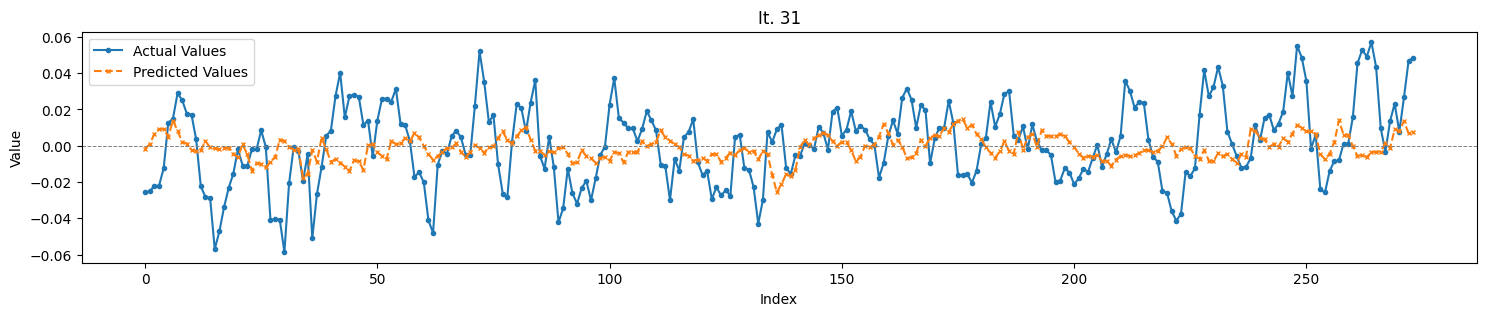

RMSE: 0.022813, STD_DEV: 0.022040, DIFF: 0.008546
Completed Iteration 31/48

Iteration 32/48
Params: n_steps: 80, lstm_units: 100, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (80, 10)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 100)               44400     
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

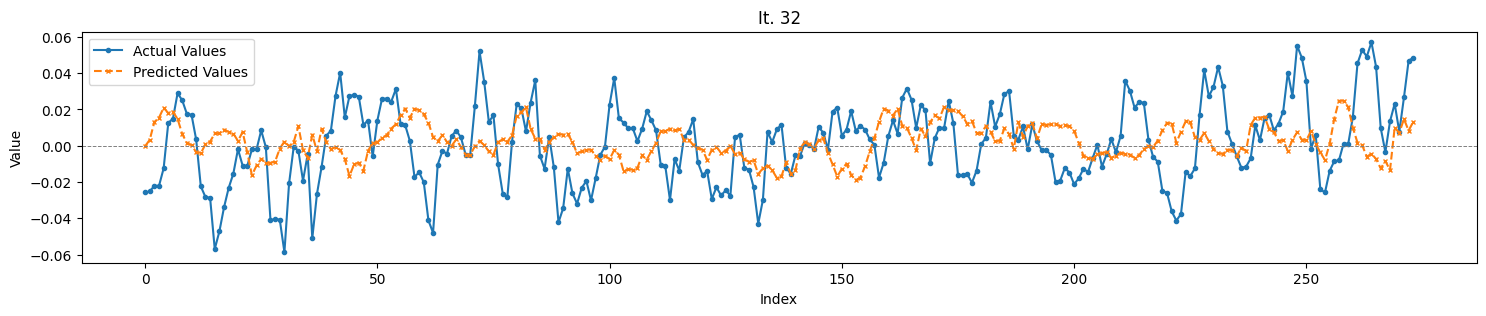

RMSE: 0.024401, STD_DEV: 0.022040, DIFF: 0.008664
Completed Iteration 32/48

Iteration 33/48
Params: n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 25)                3600      
                                                                 
 dense_32 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

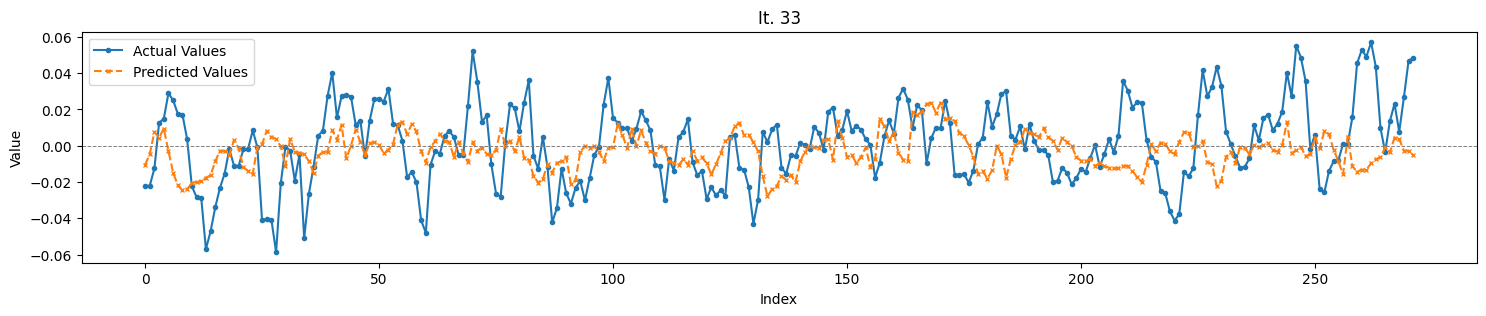

RMSE: 0.024363, STD_DEV: 0.022002, DIFF: 0.008656
Completed Iteration 33/48

Iteration 34/48
Params: n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 25)                3600      
                                                                 
 dense_33 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

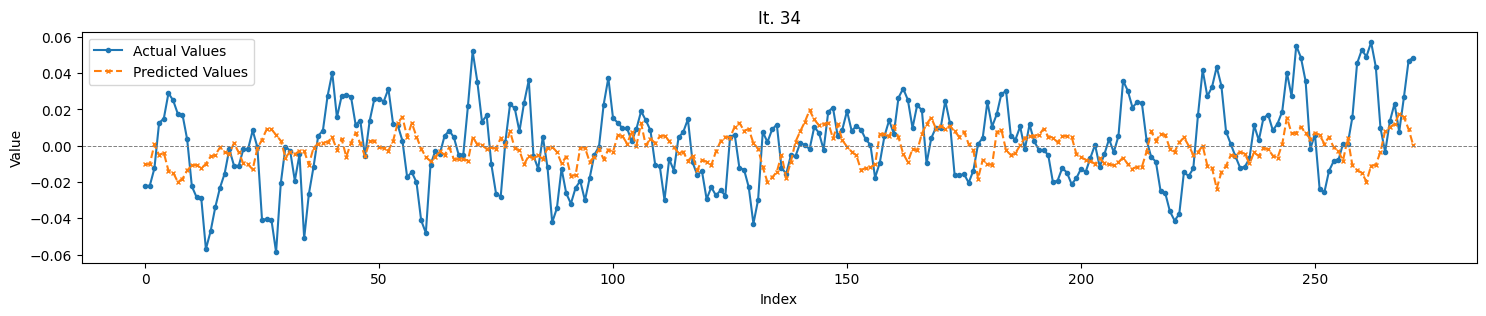

RMSE: 0.023848, STD_DEV: 0.022002, DIFF: 0.008763
Completed Iteration 34/48

Iteration 35/48
Params: n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 25)                3600      
                                                                 
 dense_34 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

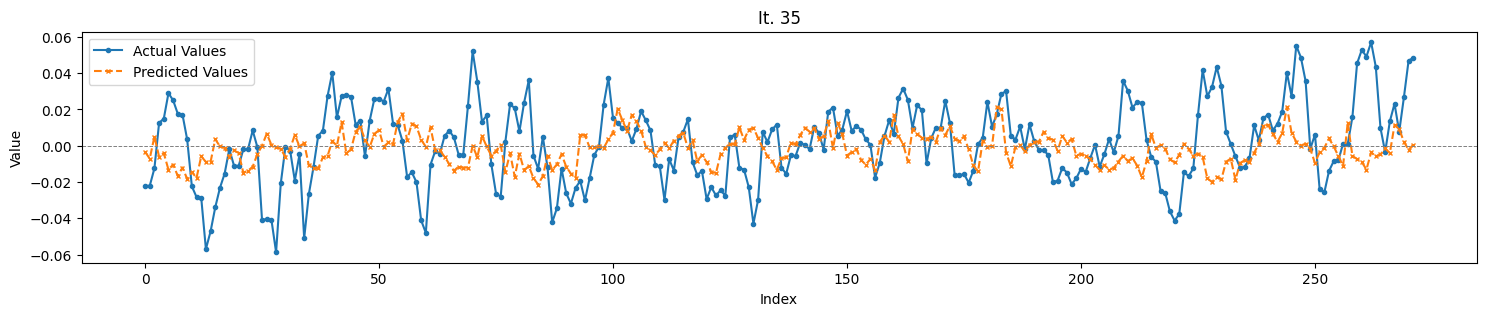

RMSE: 0.023331, STD_DEV: 0.022002, DIFF: 0.008075
Completed Iteration 35/48

Iteration 36/48
Params: n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 25)                3600      
                                                                 
 dense_35 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3626 (14.16 KB)
Trainable params: 3626 (14.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

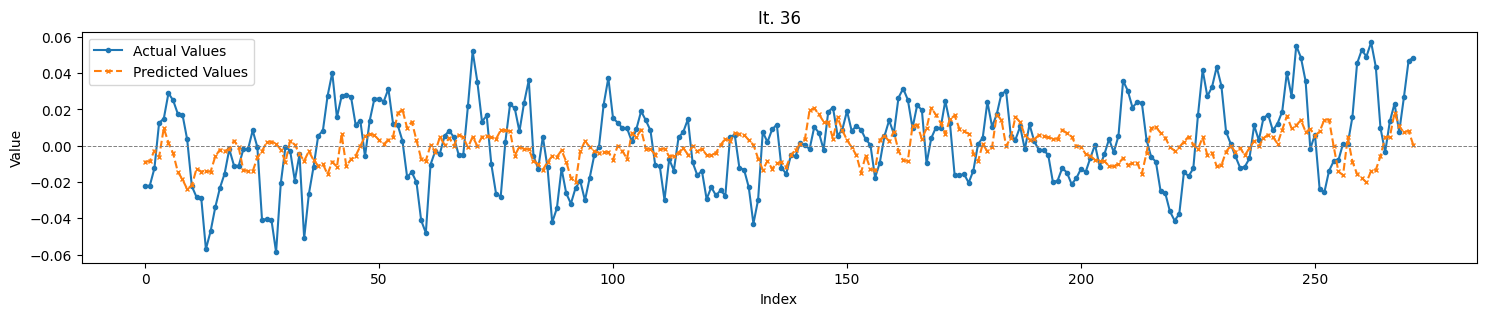

RMSE: 0.023289, STD_DEV: 0.022002, DIFF: 0.007895
Completed Iteration 36/48

Iteration 37/48
Params: n_steps: 120, lstm_units: 50, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 50)                12200     
                                                                 
 dense_36 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

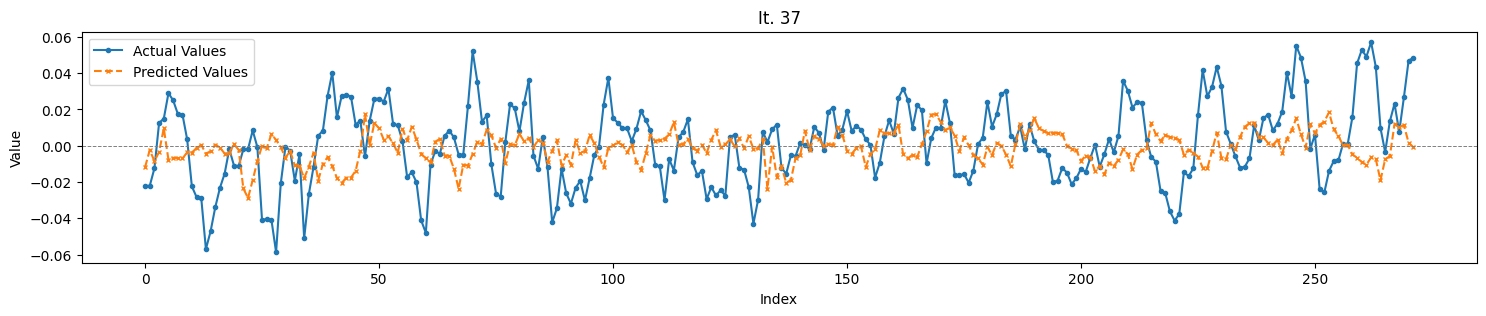

RMSE: 0.024093, STD_DEV: 0.022002, DIFF: 0.008931
Completed Iteration 37/48

Iteration 38/48
Params: n_steps: 120, lstm_units: 50, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 50)                12200     
                                                                 
 dense_37 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

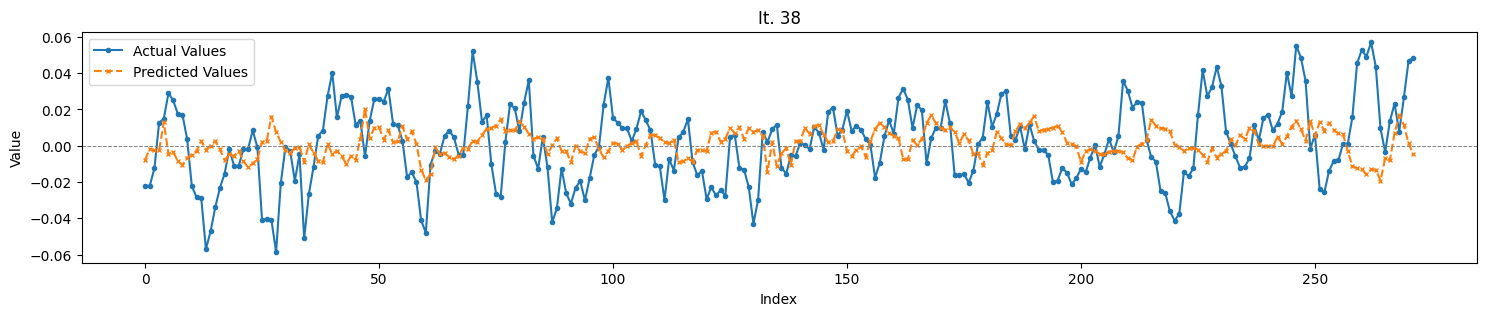

RMSE: 0.023997, STD_DEV: 0.022002, DIFF: 0.009320
Completed Iteration 38/48

Iteration 39/48
Params: n_steps: 120, lstm_units: 50, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 50)                12200     
                                                                 
 dense_38 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

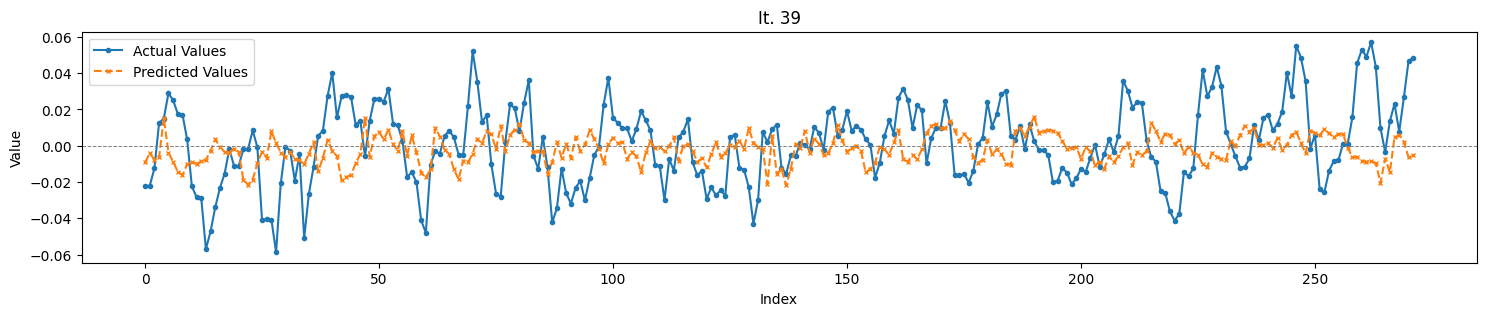

RMSE: 0.023858, STD_DEV: 0.022002, DIFF: 0.009013
Completed Iteration 39/48

Iteration 40/48
Params: n_steps: 120, lstm_units: 50, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 50)                12200     
                                                                 
 dense_39 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

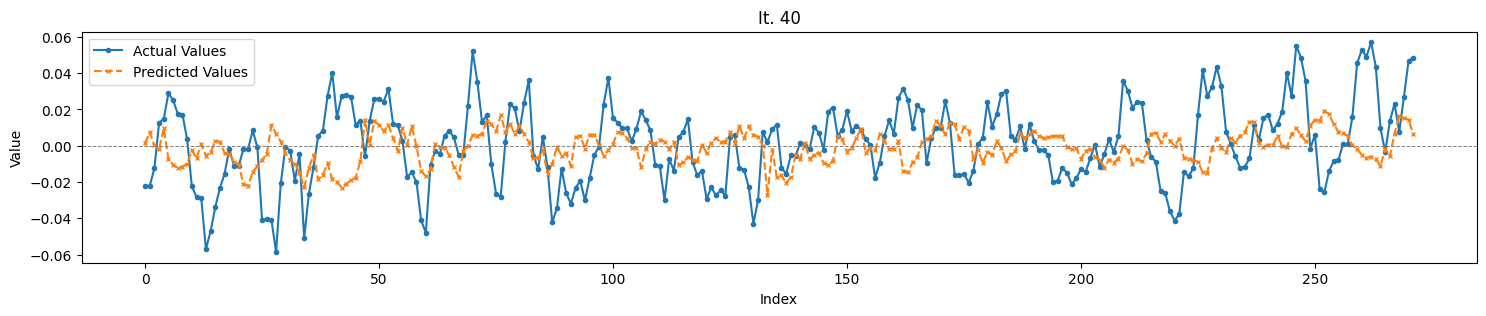

RMSE: 0.024173, STD_DEV: 0.022002, DIFF: 0.008761
Completed Iteration 40/48

Iteration 41/48
Params: n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 75)                25800     
                                                                 
 dense_40 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

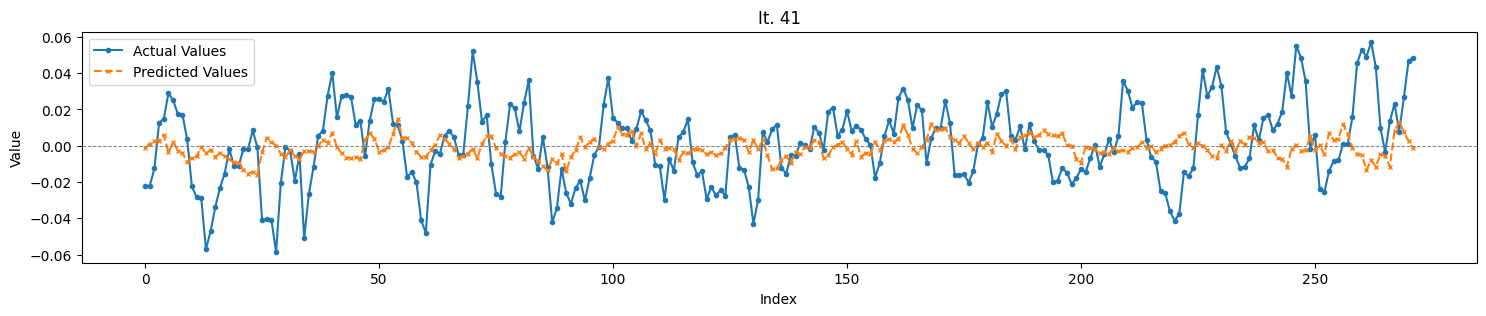

RMSE: 0.022578, STD_DEV: 0.022002, DIFF: 0.008862
Completed Iteration 41/48

Iteration 42/48
Params: n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 75)                25800     
                                                                 
 dense_41 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

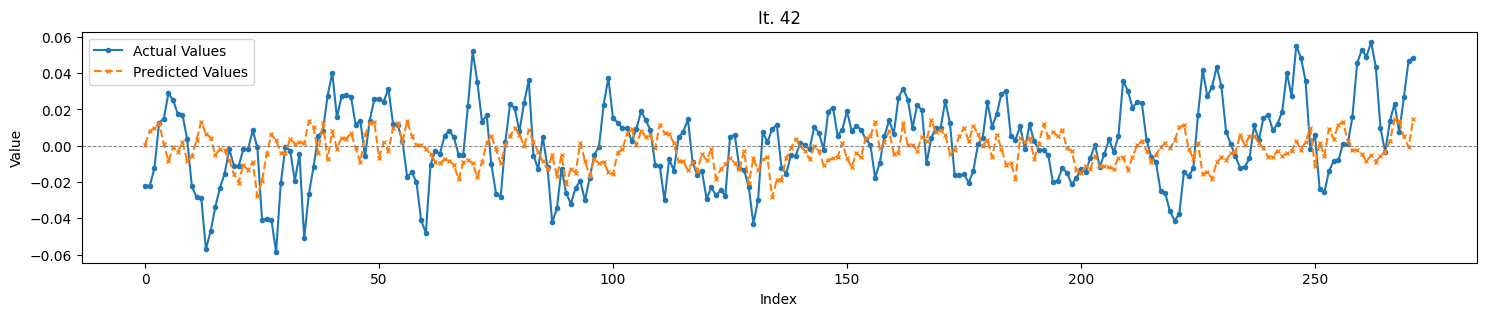

RMSE: 0.023841, STD_DEV: 0.022002, DIFF: 0.008590
Completed Iteration 42/48

Iteration 43/48
Params: n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 75)                25800     
                                                                 
 dense_42 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

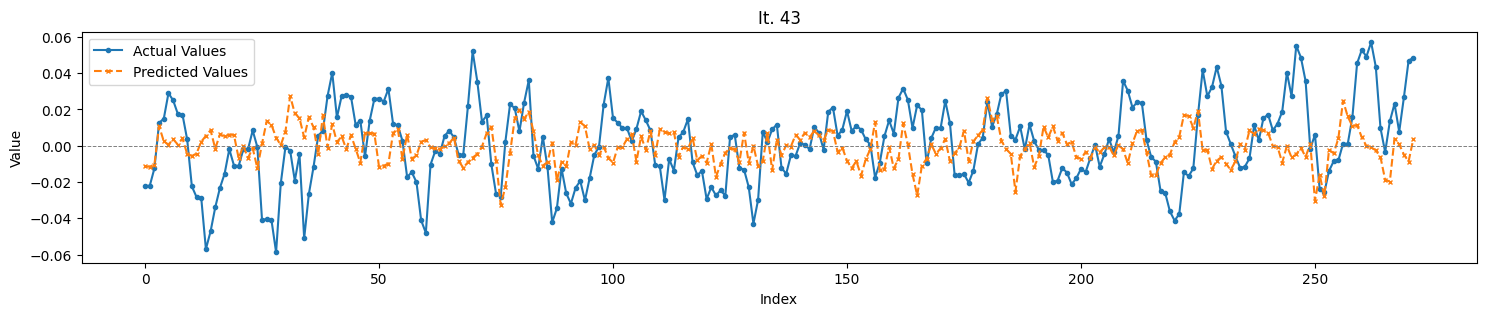

RMSE: 0.023894, STD_DEV: 0.022002, DIFF: 0.008173
Completed Iteration 43/48

Iteration 44/48
Params: n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 75)                25800     
                                                                 
 dense_43 (Dense)            (None, 1)                 76        
                                                                 
Total params: 25876 (101.08 KB)
Trainable params: 25876 (101.08 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

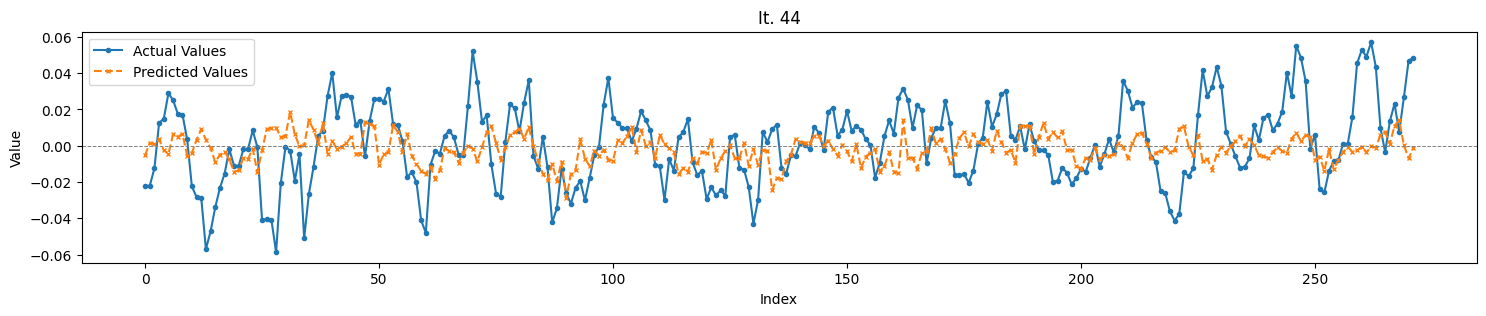

RMSE: 0.022654, STD_DEV: 0.022002, DIFF: 0.007839
Completed Iteration 44/48

Iteration 45/48
Params: n_steps: 120, lstm_units: 100, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 100)               44400     
                                                                 
 dense_44 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

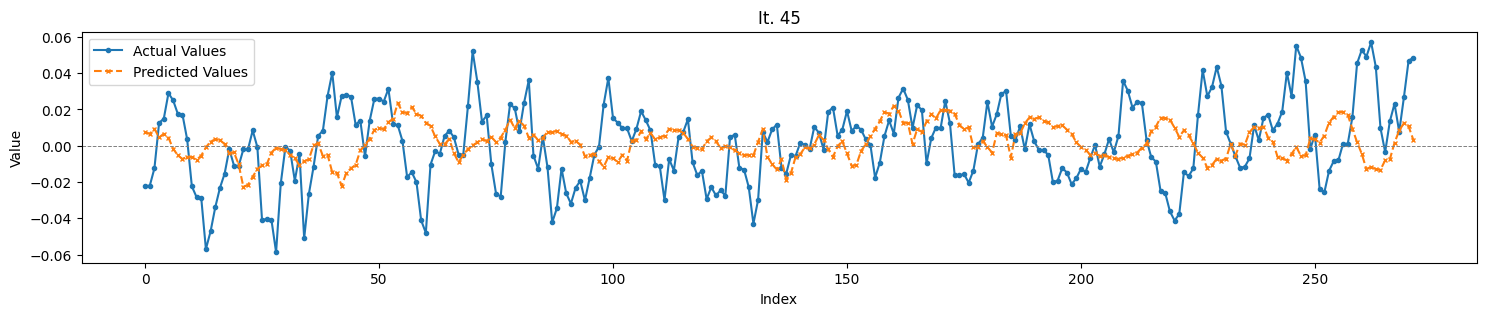

RMSE: 0.024946, STD_DEV: 0.022002, DIFF: 0.009399
Completed Iteration 45/48

Iteration 46/48
Params: n_steps: 120, lstm_units: 100, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 100)               44400     
                                                                 
 dense_45 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

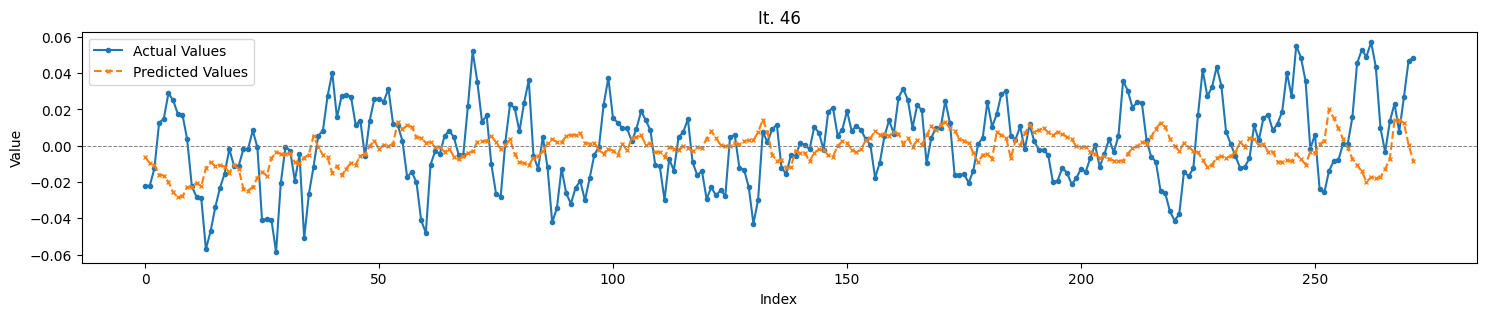

RMSE: 0.025086, STD_DEV: 0.022002, DIFF: 0.009914
Completed Iteration 46/48

Iteration 47/48
Params: n_steps: 120, lstm_units: 100, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 100)               44400     
                                                                 
 dense_46 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

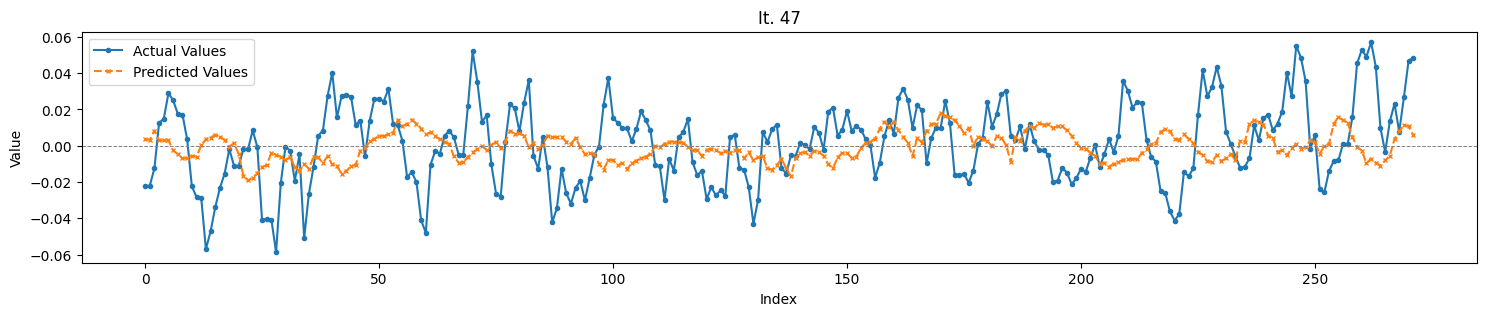

RMSE: 0.024200, STD_DEV: 0.022002, DIFF: 0.009359
Completed Iteration 47/48

Iteration 48/48
Params: n_steps: 120, lstm_units: 100, activation: relu, dropout: 0.2, num_layers: 2
Variables used: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 100)               44400     
                                                                 
 dense_47 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44501 (173.83 KB)
Trainable params: 44501 (173.83 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

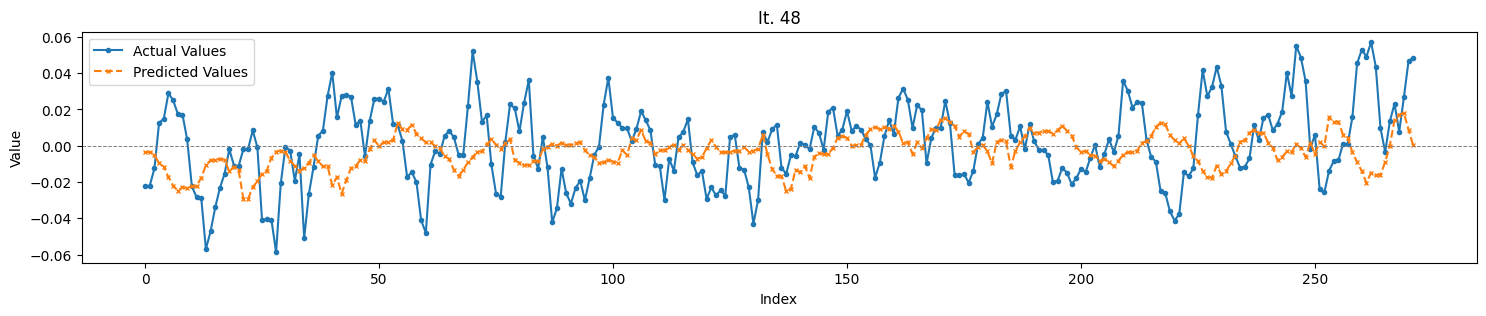

RMSE: 0.025260, STD_DEV: 0.022002, DIFF: 0.009633
Completed Iteration 48/48


In [15]:
top_results = run_model_iterations()

In [19]:
top_results = sorted(top_results, key=lambda x: x['rmse'])[:10]

Top 1 
RMSE: 0.022214, STD_DEV: 0.021968, STD_PRD: 0.009370, DIFF: 0.006544
n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023956, inv. diff> 0.008287
Trend accuracy       : 55.636
Trend up accuracy    : 57.534
Trend down accuracy  : 53.488


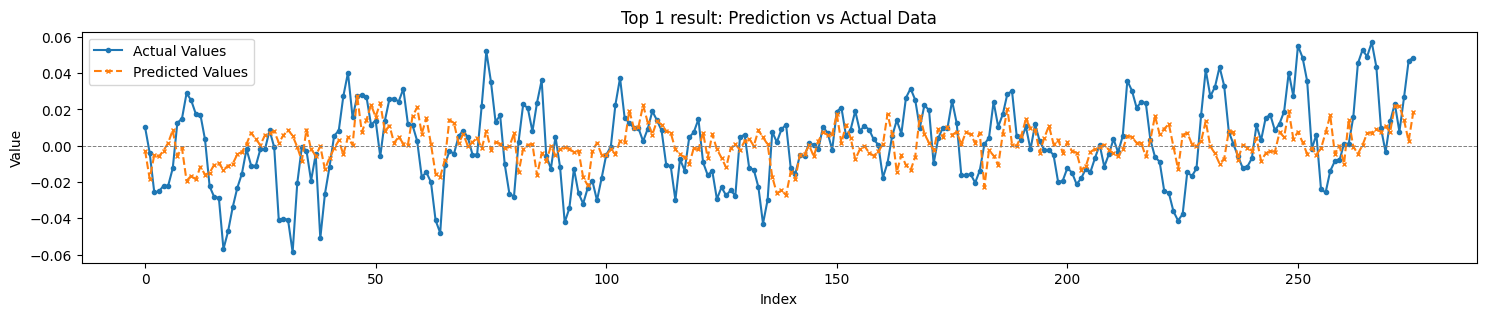

Top 2 
RMSE: 0.022654, STD_DEV: 0.022002, STD_PRD: 0.007627, DIFF: 0.007839
n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.2, batch_size: 64, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023291, inv. diff> 0.008477
Trend accuracy       : 52.768
Trend up accuracy    : 42.069
Trend down accuracy  : 65.079


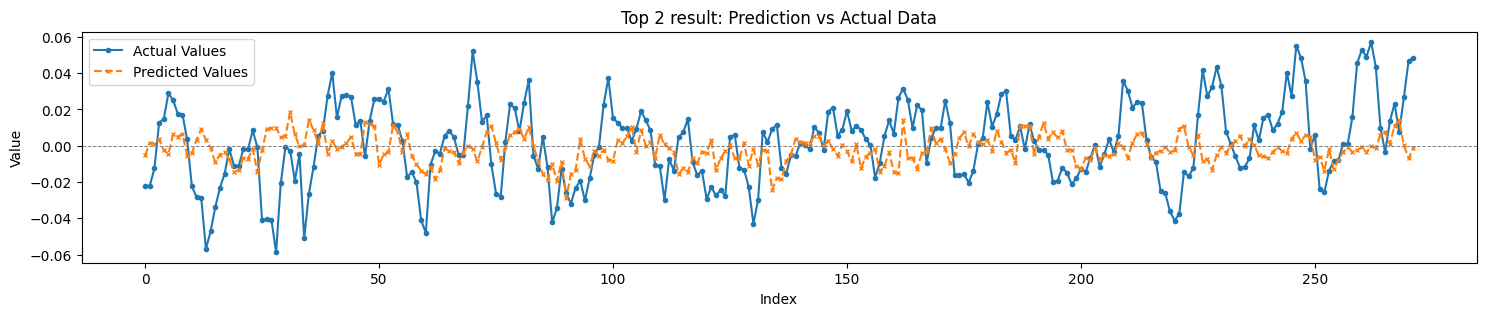

Top 3 
RMSE: 0.023289, STD_DEV: 0.022002, STD_PRD: 0.008787, DIFF: 0.007895
n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.2, batch_size: 64, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023707, inv. diff> 0.008312
Trend accuracy       : 53.506
Trend up accuracy    : 50.345
Trend down accuracy  : 57.143


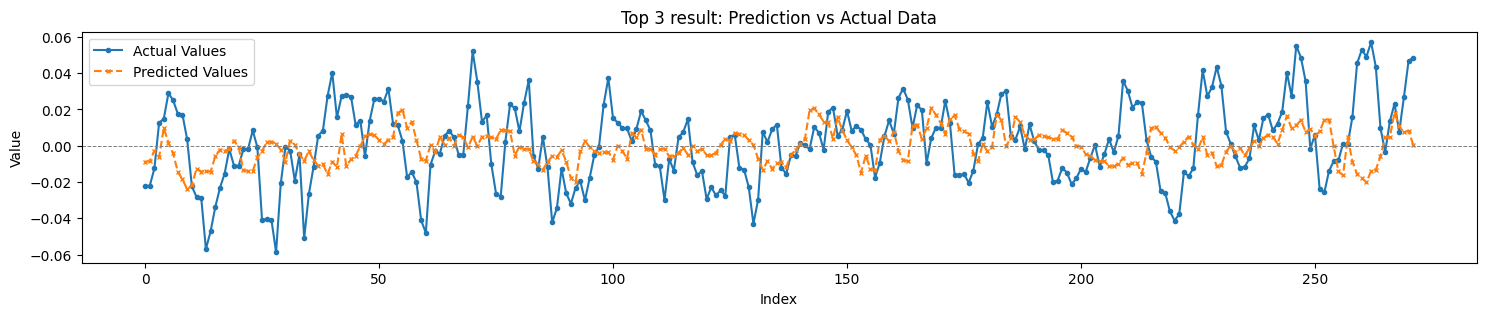

Top 4 
RMSE: 0.023331, STD_DEV: 0.022002, STD_PRD: 0.008510, DIFF: 0.008075
n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.2, batch_size: 128, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023596, inv. diff> 0.008340
Trend accuracy       : 54.982
Trend up accuracy    : 46.207
Trend down accuracy  : 65.079


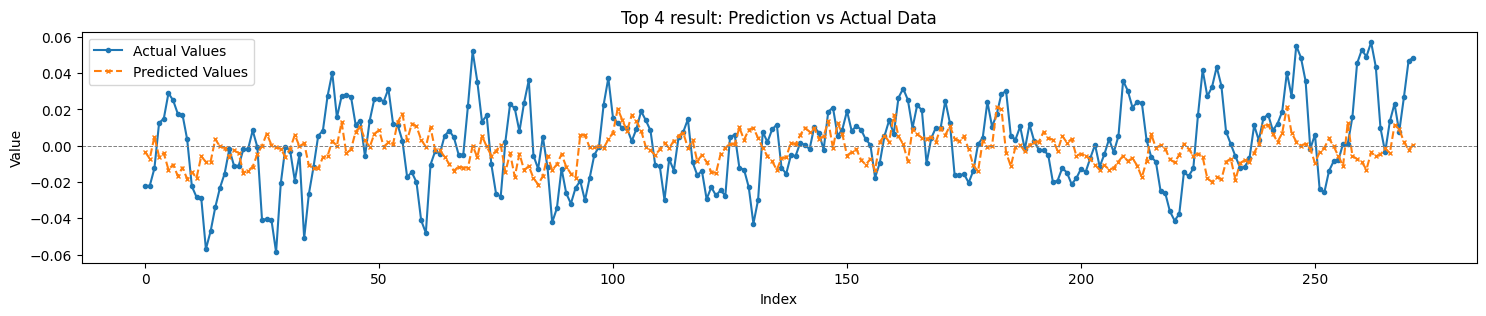

Top 5 
RMSE: 0.023485, STD_DEV: 0.022040, STD_PRD: 0.009289, DIFF: 0.007821
n_steps: 80, lstm_units: 75, activation: relu, dropout: 0.2, batch_size: 64, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023932, inv. diff> 0.008267
Trend accuracy       : 50.916
Trend up accuracy    : 48.966
Trend down accuracy  : 53.125


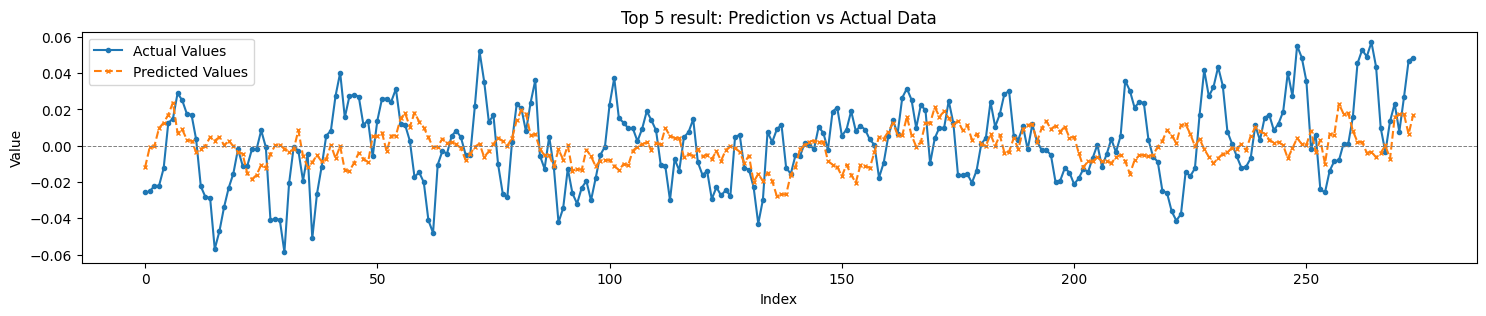

Top 6 
RMSE: 0.023492, STD_DEV: 0.022040, STD_PRD: 0.009017, DIFF: 0.007964
n_steps: 80, lstm_units: 25, activation: relu, dropout: 0.2, batch_size: 128, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023824, inv. diff> 0.008296
Trend accuracy       : 51.648
Trend up accuracy    : 52.414
Trend down accuracy  : 50.781


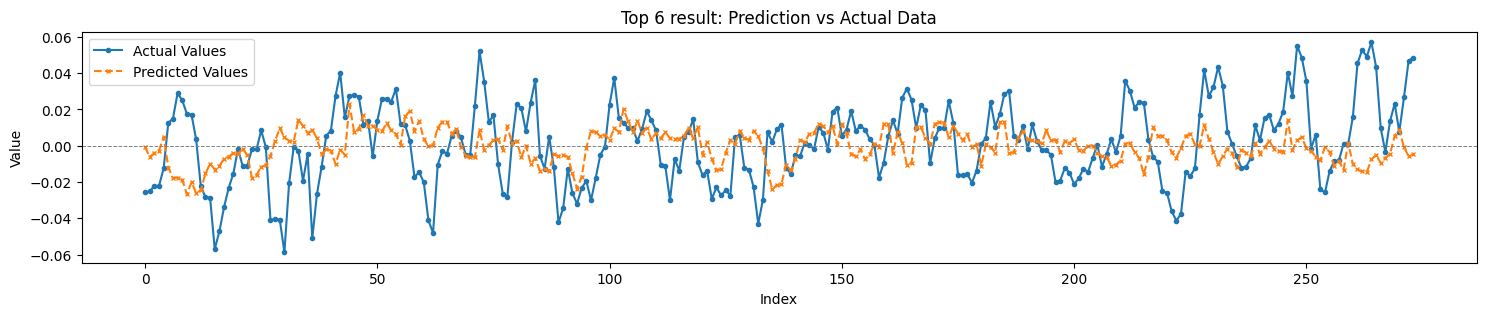

Top 7 
RMSE: 0.023717, STD_DEV: 0.021968, STD_PRD: 0.009200, DIFF: 0.008133
n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023942, inv. diff> 0.008358
Trend accuracy       : 53.091
Trend up accuracy    : 57.534
Trend down accuracy  : 48.062


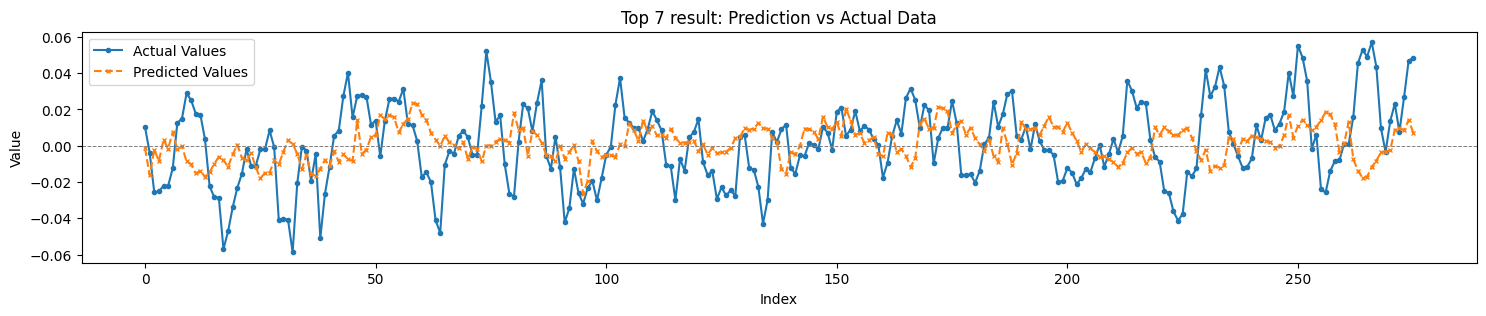

Top 8 
RMSE: 0.023894, STD_DEV: 0.022002, STD_PRD: 0.009440, DIFF: 0.008173
n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.2, batch_size: 128, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023952, inv. diff> 0.008231
Trend accuracy       : 46.125
Trend up accuracy    : 42.069
Trend down accuracy  : 50.794


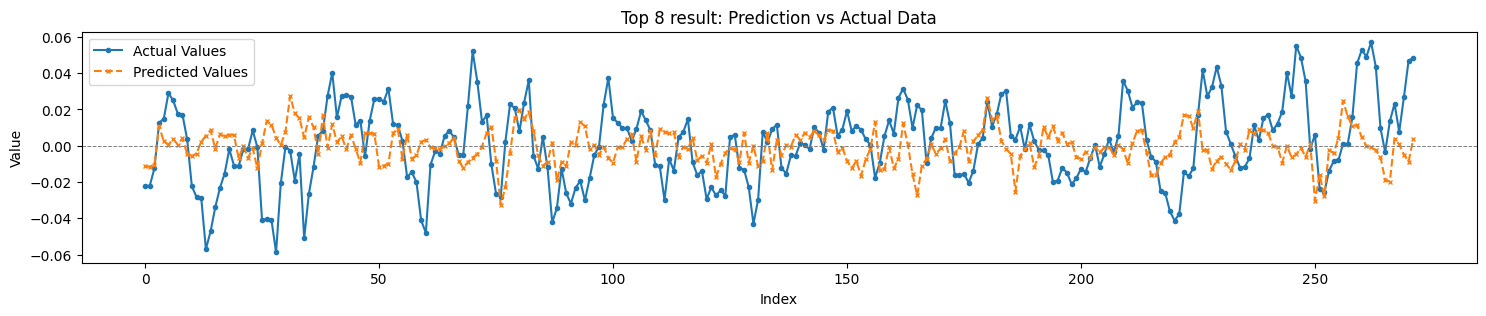

Top 9 
RMSE: 0.023929, STD_DEV: 0.021968, STD_PRD: 0.009807, DIFF: 0.008041
n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.2, batch_size: 128, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024092, inv. diff> 0.008205
Trend accuracy       : 51.273
Trend up accuracy    : 39.726
Trend down accuracy  : 64.341


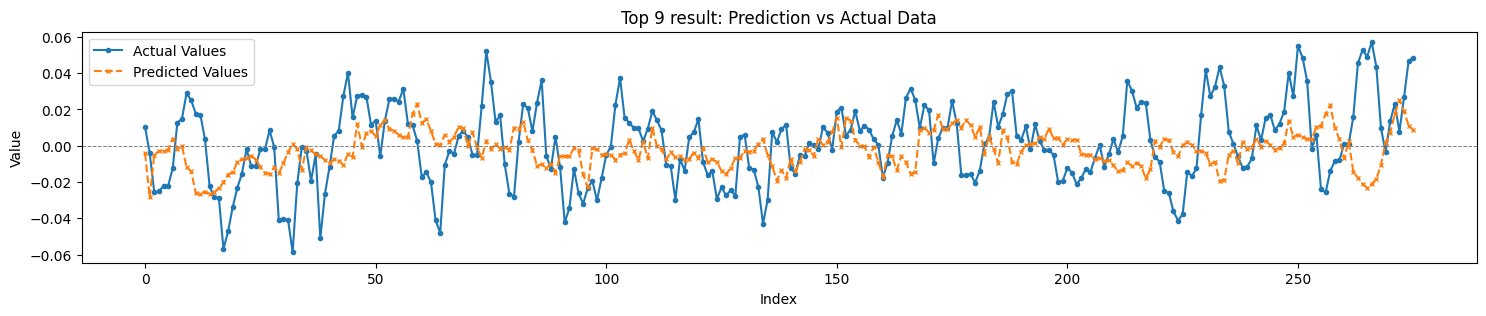

Top 10 
RMSE: 0.024815, STD_DEV: 0.022040, STD_PRD: 0.011791, DIFF: 0.007900
n_steps: 80, lstm_units: 75, activation: relu, dropout: 0.15, batch_size: 64, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.025007, inv. diff> 0.008091
Trend accuracy       : 47.985
Trend up accuracy    : 43.448
Trend down accuracy  : 53.125


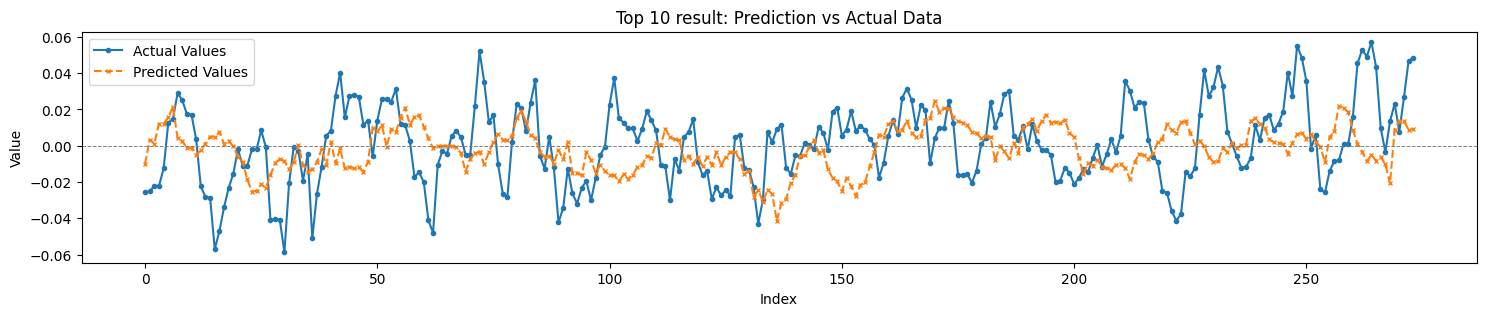

In [20]:
for i,result in enumerate(top_results,1):
    print(f"Top {i} ")
    diff = (result['rmse']- result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0
    result['diff'] = diff
    print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, DIFF: {:.6f}".format(result['rmse'], result['std_dev'], np.std(result['predictions']), diff))
    print("n_steps: {}, lstm_units: {}, activation: {}, dropout: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['lstm_units'], result['activation'], result['dropout'], result['batch_size'], result['epochs']))
    print("Feature list: ", result['feature_list'])

    # var_tot     = set(variable_options)
    # fea_list    = set(result['feature_list'])
    # print("Discarded var: {}".format(var_tot - fea_list))

    result['inv_rmse'] = inv_rmse = rmse(result['true_values'], result['predictions']*-1)
    inv_diff = (inv_rmse - result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0
    print("Inv. rmse> {:.6f}, inv. diff> {:.6f}".format(inv_rmse, inv_diff))

    # calculate trend prediction percentage

    trend_up_true   = 0
    trend_down_true = 0
    trend_up_pred   = 0
    trend_down_pred = 0

    for j in range(len(result['true_values'])-1):
        if result['true_values'][j] > 0.0:
            trend_up_pred += 1
            if result['predictions'][j] > 0.0:
                trend_up_true += 1
        if result['true_values'][j] < 0.0:
            trend_down_pred += 1
            if result['predictions'][j] < 0.0:
                trend_down_true += 1

    trend_true      = trend_up_true + trend_down_true
    trend_pred      = trend_up_pred + trend_down_pred 
    trend_accuracy  = trend_true/trend_pred
    print("Trend accuracy       : {:.3f}".format(trend_accuracy*100))
    print("Trend up accuracy    : {:.3f}".format(trend_up_true*100/trend_up_pred))
    print("Trend down accuracy  : {:.3f}".format(trend_down_true*100/trend_down_pred))

    # plot_predictions(result['true_values'], result['predictions'],250, title=f"Top {i} result: Prediction vs Actual Data")
    plot_predictions(result['true_values'], result['predictions'],-1, title=f"Top {i} result: Prediction vs Actual Data")


In [18]:
# export the best result predictions and true values to a csv file
best_result = top_results[0]
best_result_df = pd.DataFrame({'True Values': best_result['true_values'], 'Predictions': best_result['predictions'].flatten()})
best_result_df.to_csv('../output/lstm_best_result.csv', index=False)